In [27]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch

In [28]:
print(os.getcwd())

C:\Users\Ali\Assessment


In [29]:
def read_files_from_folder(folder_path):
    """
    Reads all CSV files in the specified folder and returns a dictionary of DataFrames.
    Each key is the filename, and the value is the DataFrame containing the data.
    """
    data_dict = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Process only CSV files
            file_path = os.path.join(folder_path, file_name)
            try:
                data = pd.read_csv(file_path)
                if {'ts', 'gt', 's1'}.issubset(data.columns):  # Check required columns
                    data_dict[file_name] = data
                else:
                    print(f"File {file_name} skipped: Missing required columns.")
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    return data_dict

In [30]:
# read the files using the written function
folder_path = "test_data"  # Replace with the path to your data folder
data_dict = read_files_from_folder(folder_path)
print(f"Loaded {len(data_dict)} files.")

Loaded 100 files.


In [31]:
def analyze_data(data_dict):
    """
    Analyzes each file to compute amplitudes and frequencies of GT and S1,
    as well as the noise amplitude and frequency.
    Returns a list of results for all files.
    """
    results = []

    for file_name, data in data_dict.items():
        try:
            # Extract time and signals
            TS = data['ts']
            GT = data['gt']
            S1 = data['s1']
            
            # Calculate amplitudes
            gt_amplitude = (GT.max() - GT.min()) / 2
            s1_amplitude = (S1.max() - S1.min()) / 2
            
            # Calculate frequencies using FFT
            fs = 1 / np.mean(np.diff(TS))  # Sampling frequency
            freqs, psd_gt = welch(GT, fs=fs)
            freqs, psd_s1 = welch(S1, fs=fs)
            gt_frequency = freqs[np.argmax(psd_gt)]
            s1_frequency = freqs[np.argmax(psd_s1)]
            
            # Noise analysis
            noise = S1 - GT
            noise_amplitude = np.max(np.abs(noise))
            freqs_noise, psd_noise = welch(noise, fs=fs)
            noise_frequency = freqs_noise[np.argmax(psd_noise)]
            
            # Append results
            results.append({
                'File': file_name,
                'GT Amplitude': gt_amplitude,
                'S1 Amplitude': s1_amplitude,
                'GT Frequency': gt_frequency,
                'S1 Frequency': s1_frequency,
                'Noise Amplitude': noise_amplitude,
                'Noise Frequency': noise_frequency
            })

        except Exception as e:
            print(f"Error analyzing {file_name}: {e}")
    
    return pd.DataFrame(results)

In [32]:
# Use the analyze data function
results_df = analyze_data(data_dict)
print(results_df.head())

           File  GT Amplitude  S1 Amplitude  GT Frequency  S1 Frequency  \
0  test_001.csv           1.2      1.282858       3.90625       3.90625   
1  test_002.csv           1.2      1.293666       3.90625       3.90625   
2  test_003.csv           1.2      1.244537       3.90625       3.90625   
3  test_004.csv           1.2      1.213996       3.90625       3.90625   
4  test_005.csv           1.2      1.305477       3.90625       3.90625   

   Noise Amplitude  Noise Frequency  
0         0.111976         19.53125  
1         0.097665         15.62500  
2         0.121781         15.62500  
3         0.045635         11.71875  
4         0.113741         11.71875  


In [52]:
def plot_results(results_df):
    """
    Plots amplitudes, noise amplitudes, and noise frequencies of S1 with limit lines and red points for violations.
    """
    encoder_ids = [int(f.split('_')[1].split('.')[0]) for f in results_df['File']]
    
    # Set limits
    amplitude_limit = 2
    noise_amplitude_limit = 0.09
    noise_frequency_limit = 15

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot S1 Amplitude
    axs[0].scatter(encoder_ids, results_df['S1 Amplitude'], c=(results_df['S1 Amplitude'] > amplitude_limit).map({True: 'red', False: 'blue'}))
    axs[0].axhline(y=amplitude_limit, color='green', linestyle='--', label="Limit")
    axs[0].set_title("S1 Amplitude vs Encoder Recording")
    axs[0].set_xlabel("Encoder Recording")
    axs[0].set_ylabel("Amplitude (degrees)")
    axs[0].legend()
    axs[0].set_xticks(np.arange(0, 105, 5))
    axs[0].set_yticks(np.arange(0, 2.5, 0.5))
    axs[0].grid(True, which='both', linestyle='--', alpha=0.7)
    
    # Plot Noise Amplitude
    axs[1].scatter(encoder_ids, results_df['Noise Amplitude'], c=(results_df['Noise Amplitude'] > noise_amplitude_limit).map({True: 'red', False: 'blue'}))
    axs[1].axhline(y=noise_amplitude_limit, color='green', linestyle='--', label="Limit")
    axs[1].set_title("Noise Amplitude vs Encoder Recording")
    axs[1].set_xlabel("Encoder Recording")
    axs[1].set_ylabel("Amplitude (degrees)")
    axs[1].legend()
    axs[1].set_xticks(np.arange(0, 105, 5))
    axs[1].set_yticks(np.arange(0, 0.14, 0.02))
    axs[1].grid(True, which='both', linestyle='--', alpha=0.7)
    
    # Plot Noise Frequency
    axs[2].scatter(encoder_ids, results_df['Noise Frequency'], c=(results_df['Noise Frequency'] > noise_frequency_limit).map({True: 'red', False: 'blue'}))
    axs[2].axhline(y=noise_frequency_limit, color='green', linestyle='--', label="Limit")
    axs[2].set_title("Noise Frequency vs Encoder Recording")
    axs[2].set_xlabel("Encoder Recording")
    axs[2].set_ylabel("Frequency (Hz)")
    axs[2].legend()
    axs[2].set_xticks(np.arange(0, 105, 5))
    axs[2].set_yticks(np.arange(0, 20, 2))
    axs[2].grid(True, which='both', linestyle='--', alpha=0.7)
    
    # Show plots
    plt.tight_layout()
    plt.show()

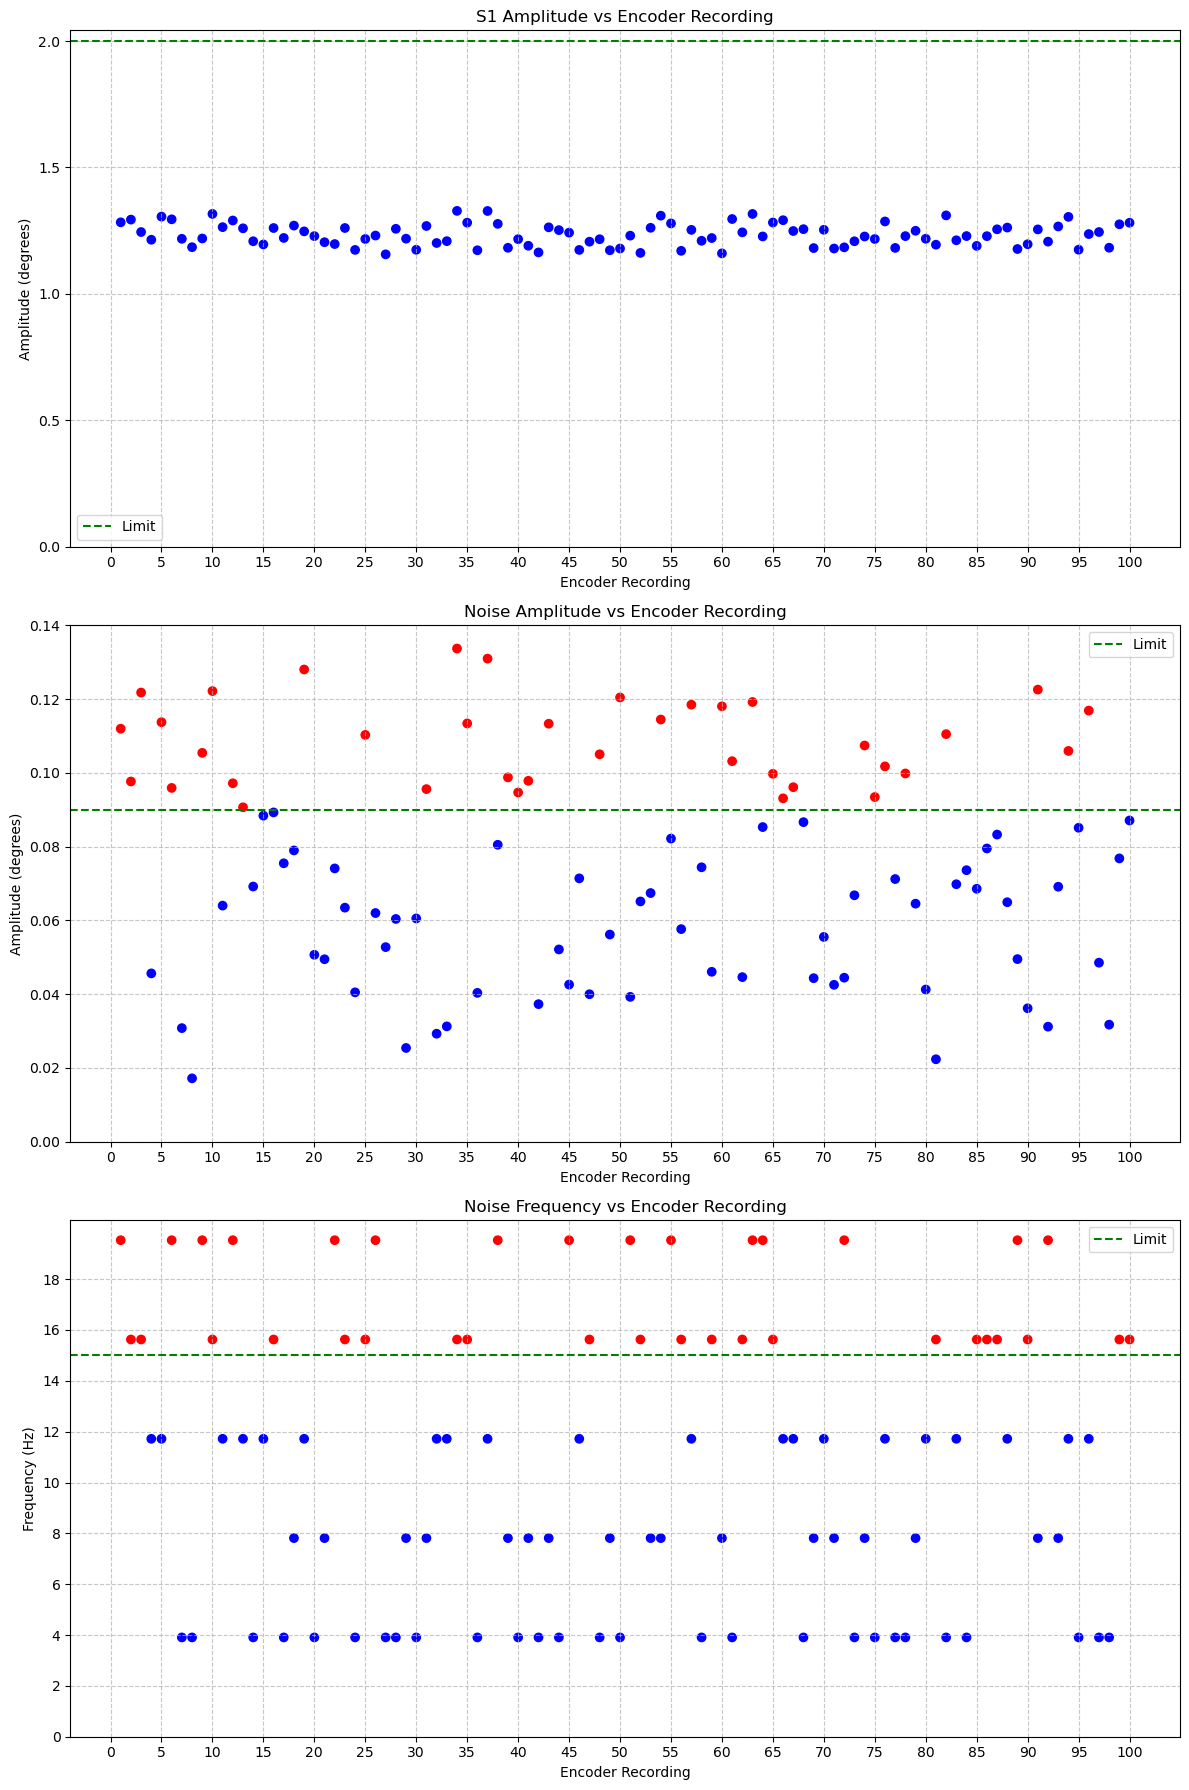

In [53]:
# Plot the results obtained
plot_results(results_df)

In [35]:
def add_pass_fail(results_df):
    """
    Adds PASS/FAIL columns for each limit and overall compliance to the results DataFrame.
    """
    results_df['Amplitude PASS'] = results_df['S1 Amplitude'] <= 2
    results_df['Noise Amplitude PASS'] = results_df['Noise Amplitude'] <= 0.09
    results_df['Noise Frequency PASS'] = results_df['Noise Frequency'] <= 15
    results_df['Overall PASS'] = results_df[['Amplitude PASS', 'Noise Amplitude PASS', 'Noise Frequency PASS']].all(axis=1)
    return results_df

def save_results(results_df, output_path):
    """
    Saves the processed results to a CSV file.
    """
    results_df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")

# Example usage
results_pf_added_df = add_pass_fail(results_df)
save_results(results_df, "analysis_results.csv")
print(results_df.head())

Results saved to analysis_results.csv
           File  GT Amplitude  S1 Amplitude  GT Frequency  S1 Frequency  \
0  test_001.csv           1.2      1.282858       3.90625       3.90625   
1  test_002.csv           1.2      1.293666       3.90625       3.90625   
2  test_003.csv           1.2      1.244537       3.90625       3.90625   
3  test_004.csv           1.2      1.213996       3.90625       3.90625   
4  test_005.csv           1.2      1.305477       3.90625       3.90625   

   Noise Amplitude  Noise Frequency  Amplitude PASS  Noise Amplitude PASS  \
0         0.111976         19.53125            True                 False   
1         0.097665         15.62500            True                 False   
2         0.121781         15.62500            True                 False   
3         0.045635         11.71875            True                  True   
4         0.113741         11.71875            True                 False   

   Noise Frequency PASS  Overall PASS  
0       

In [36]:
#The code ends above the bottom is exploratory

In [37]:
# Define the processor function
def process_encoder_data(folder_path):
    """
    Processes encoder recordings in a folder.
    Inputs:
        folder_path: Path to the folder containing the encoder data files.
    Outputs:
        Summary of analysis and compliance for each file.
    """
    # Initialize results
    results = []

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)

        # Ensure it's a file and in CSV format
        if os.path.isfile(file_path) and file_name.endswith(".csv"):
            try:
                # Read the data file
                data = pd.read_csv(file_path)

                # Validate that required columns exist
                if not {'ts', 'gt', 's1'}.issubset(data.columns):
                    print(f"Skipping {file_name}: Missing required columns.")
                    continue

                # Extract variables
                TS = data['ts']
                GT = data['gt']
                S1 = data['s1']

                # Analysis: Amplitude check
                amplitude_exceed = (S1.max() - S1.min()) > 2

                # Analysis: Noise characteristics
                # Subtract GT from S1 to isolate noise
                noise = S1 - GT

                # Compute noise amplitude
                noise_amplitude = noise.abs().max()

                # Compute noise frequency using Welch's method
                freqs, psd = welch(noise, fs=1/np.mean(np.diff(TS)))
                noise_freq = freqs[np.argmax(psd)]

                # Check compliance
                is_compliant = not (amplitude_exceed or noise_amplitude > 0.09 or noise_freq > 15)

                # Append results
                results.append({
                    'File': file_name,
                    'Amplitude Exceeded': amplitude_exceed,
                    'Noise Amplitude': noise_amplitude,
                    'Noise Frequency': noise_freq,
                    'Compliant': is_compliant
                })

                # Optional: Plot the results
                plt.figure(figsize=(10, 6))
                plt.plot(TS, GT, label='Ground Truth (GT)', linestyle='--')
                plt.plot(TS, S1, label='Measured Position (S1)')
                plt.title(f"Signal Analysis for {file_name}")
                plt.xlabel("Time (s)")
                plt.ylabel("Position (degrees)")
                plt.legend()
                plt.show()

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    # Convert results to a DataFrame for better visualization
    results_df = pd.DataFrame(results)

    # Print summary results
    print("Analysis Summary:")
    print(results_df)

    # Save the results to a CSV file
    results_csv_path = os.path.join(folder_path, "analysis_results.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"Results saved to {results_csv_path}")


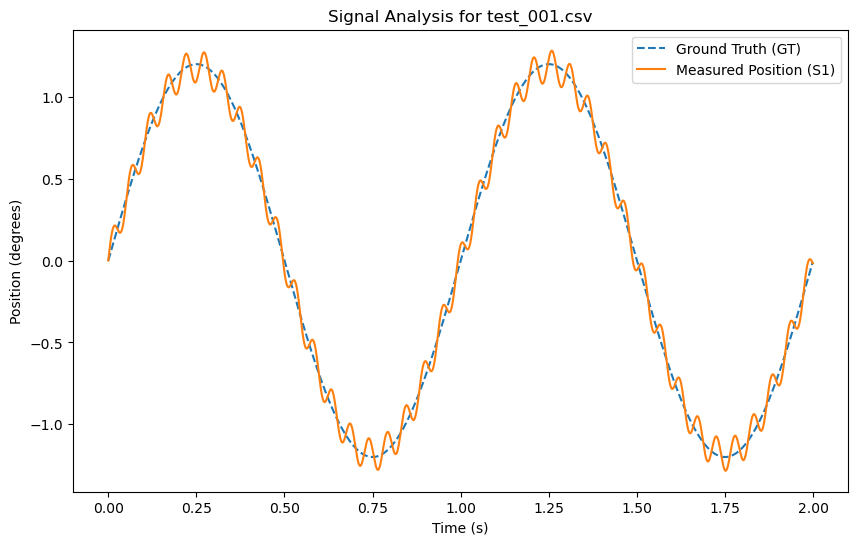

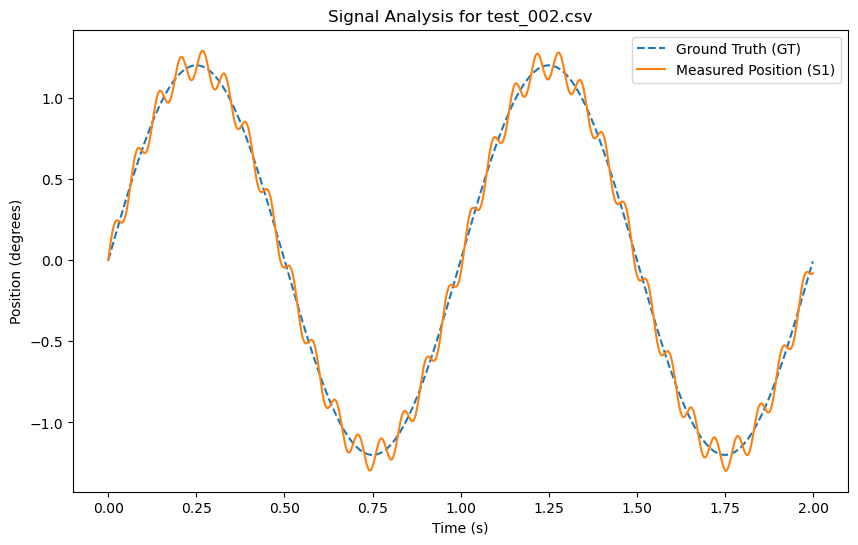

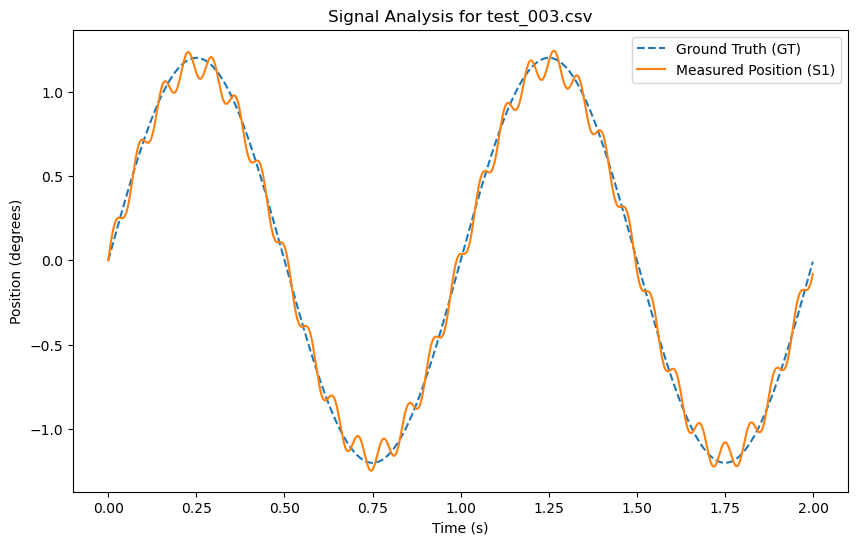

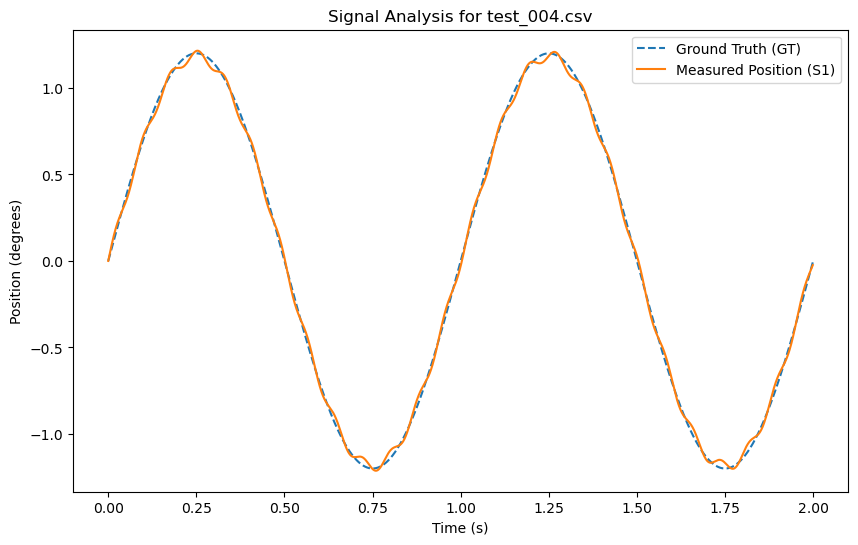

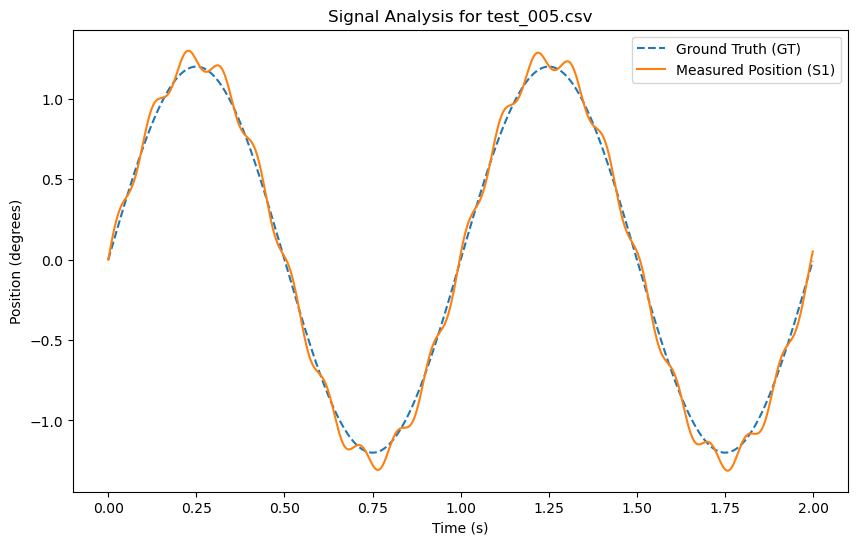

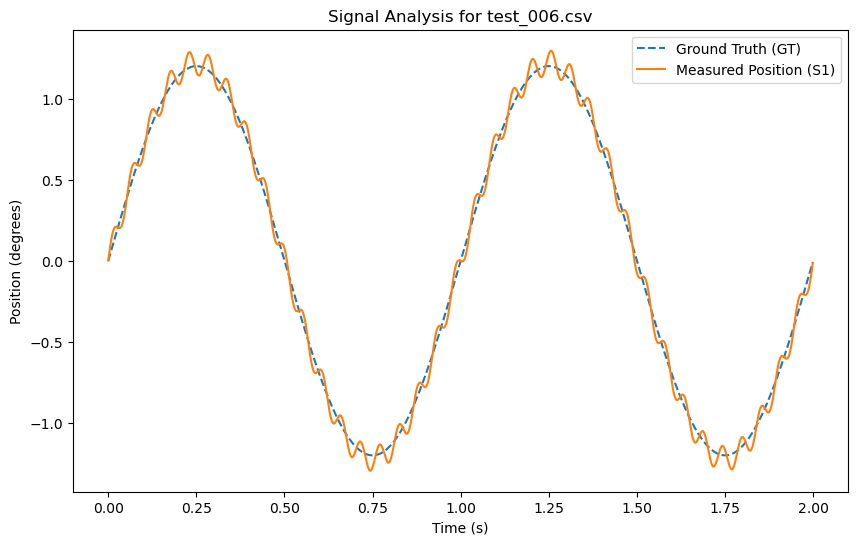

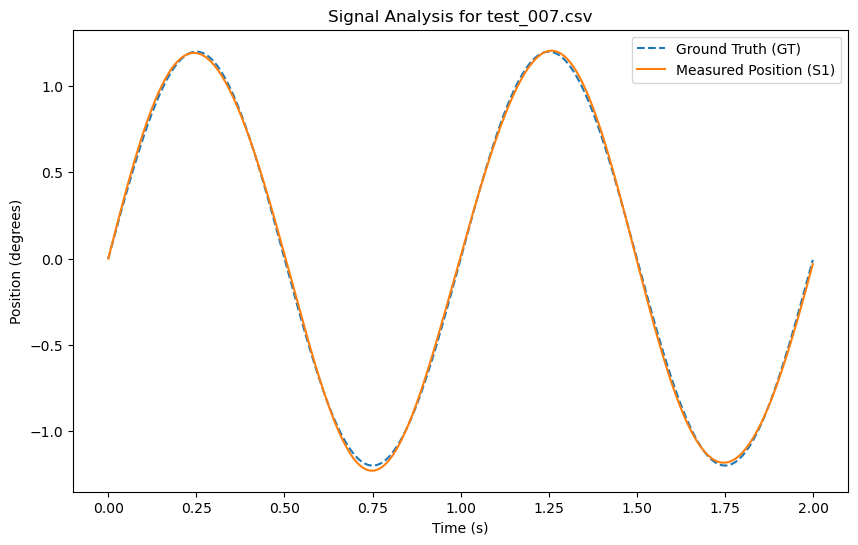

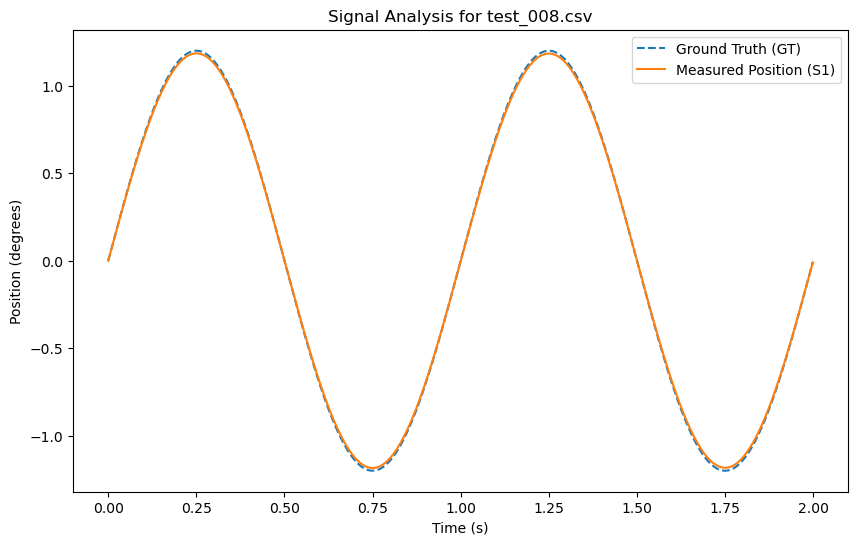

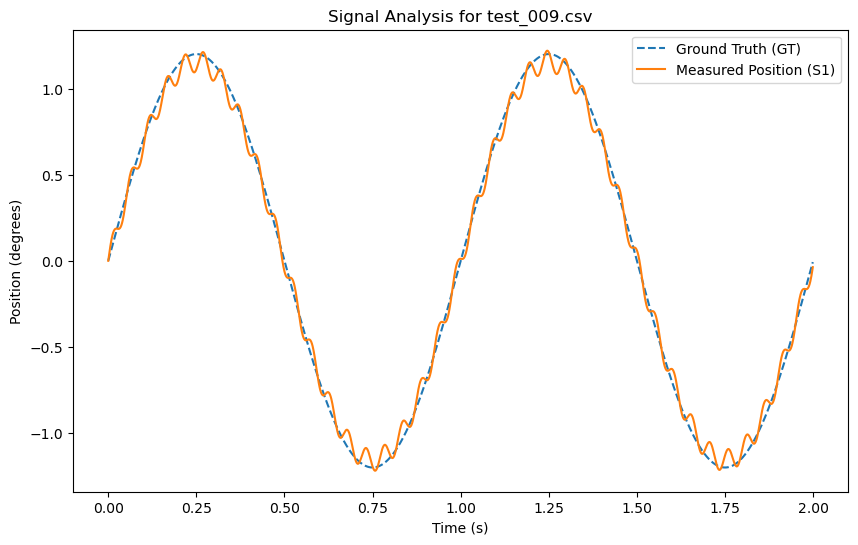

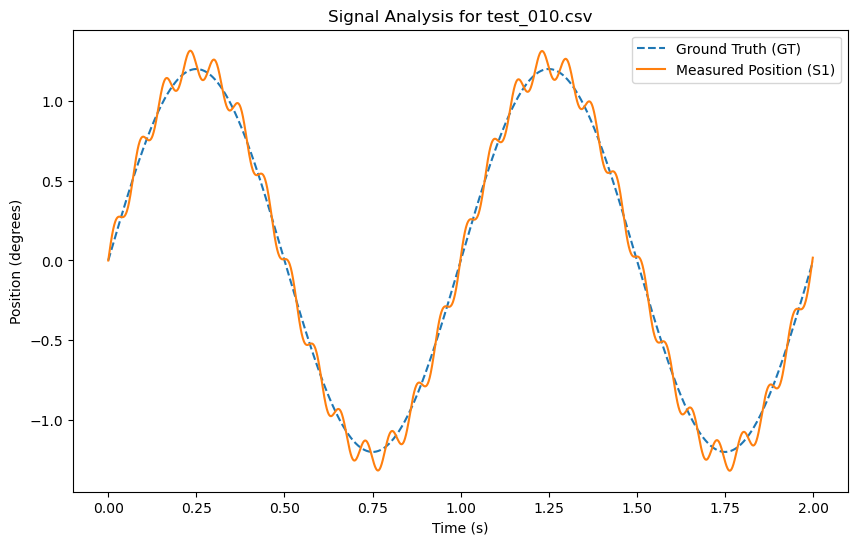

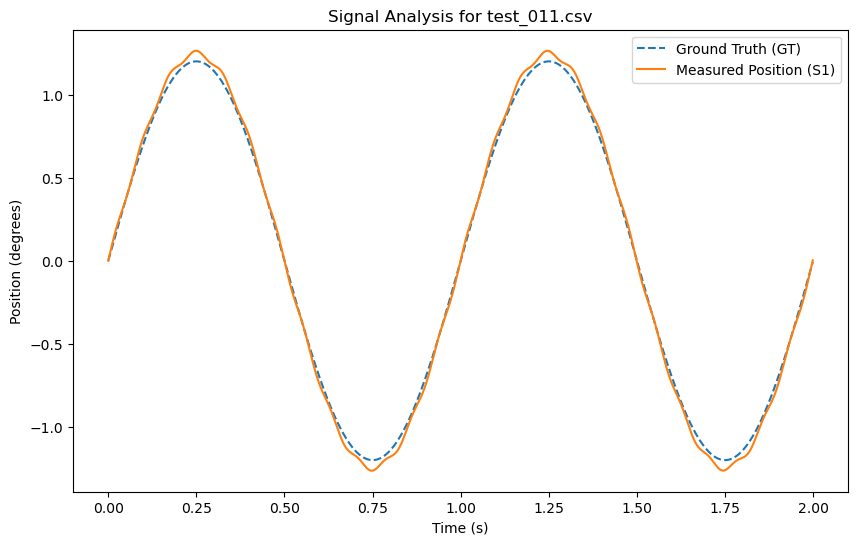

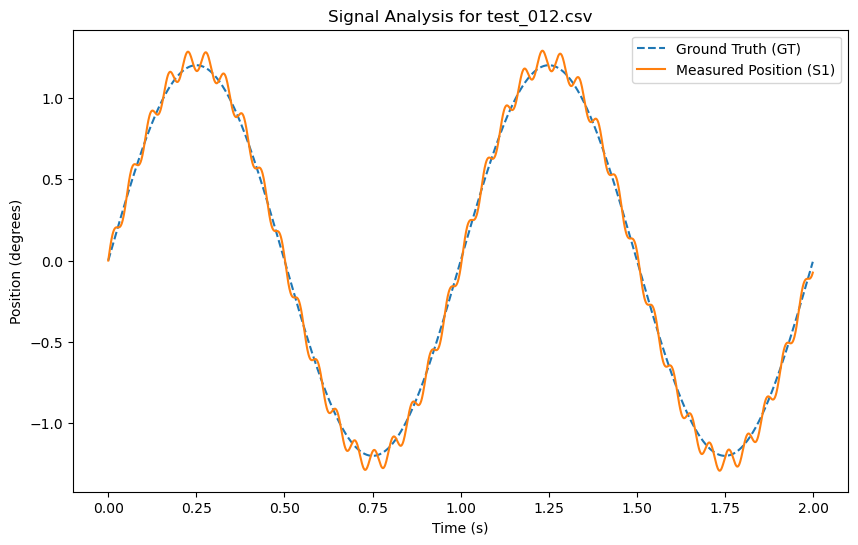

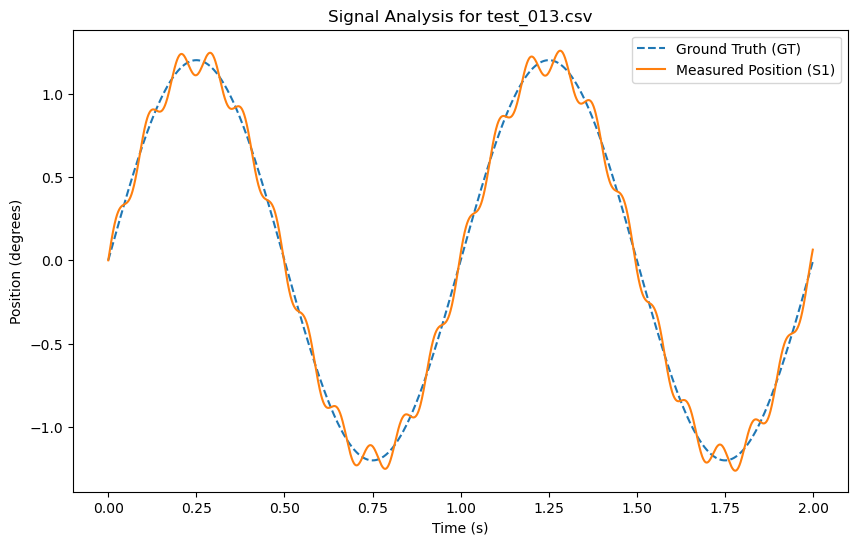

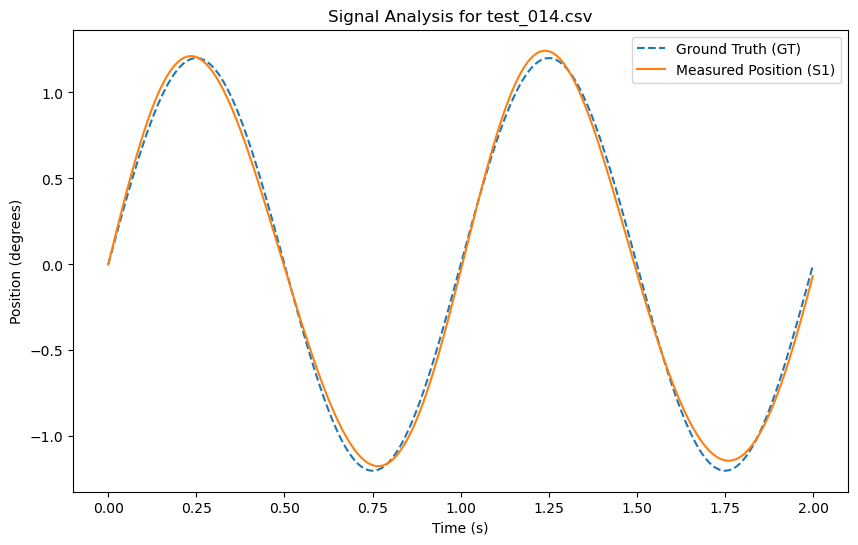

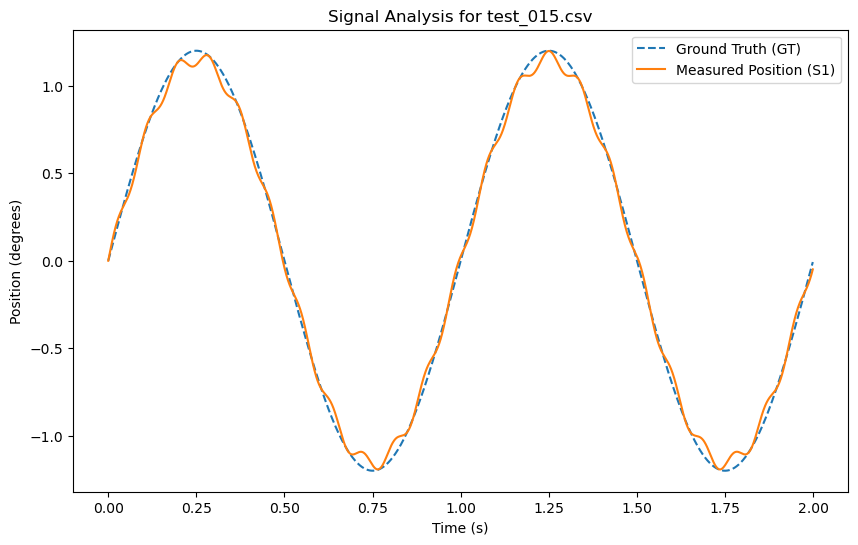

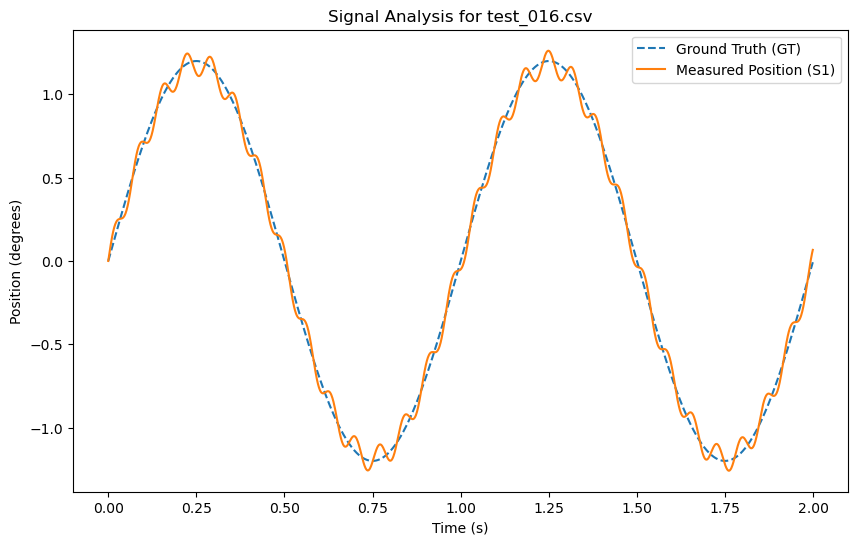

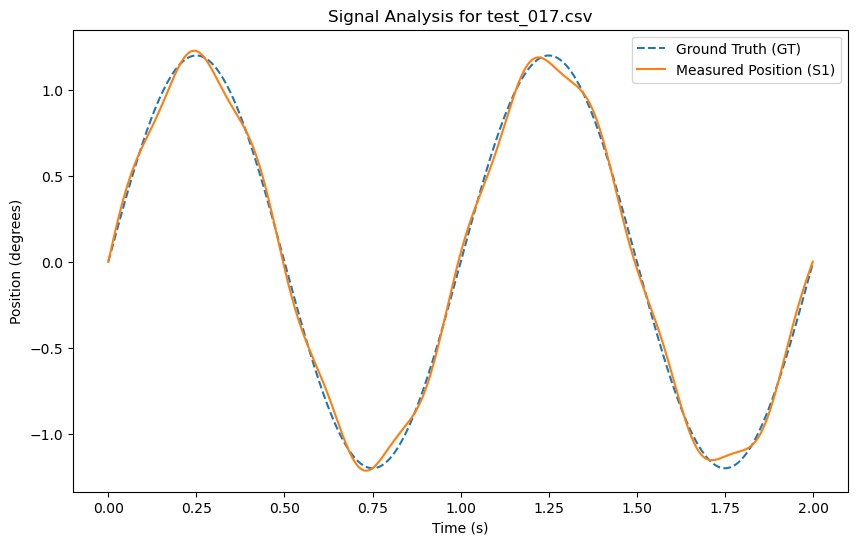

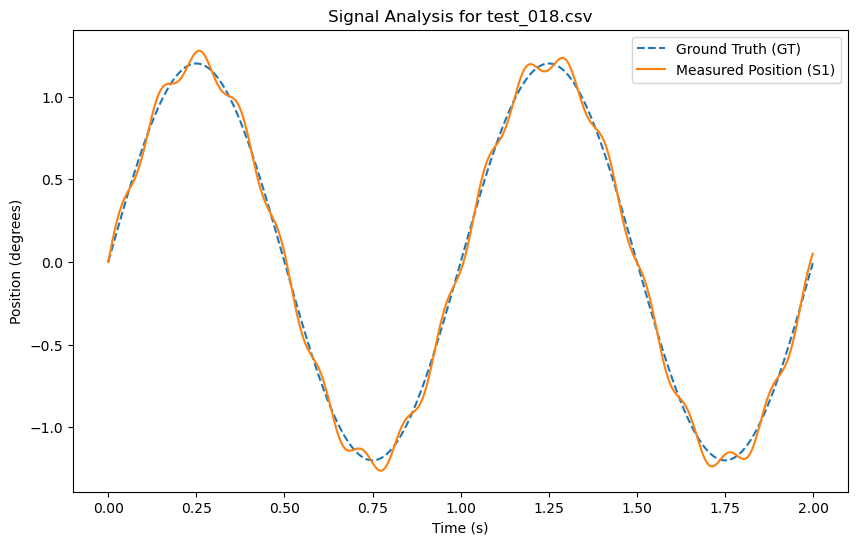

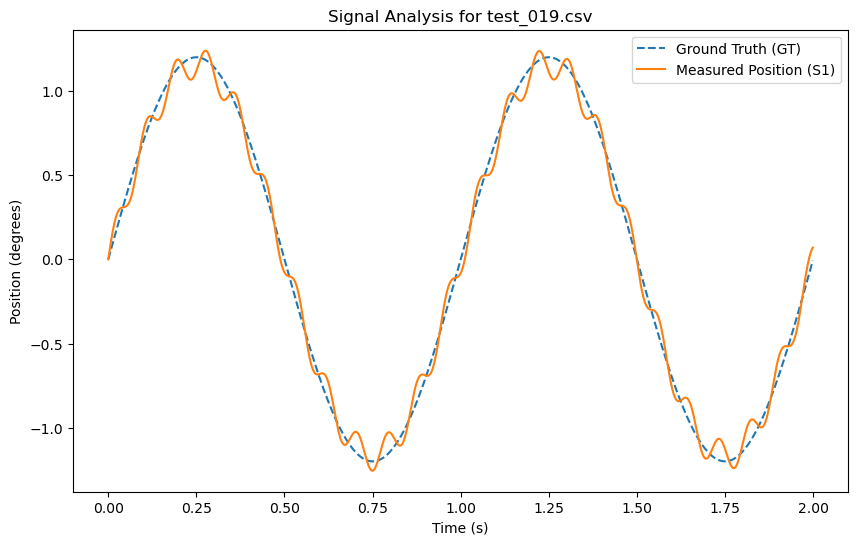

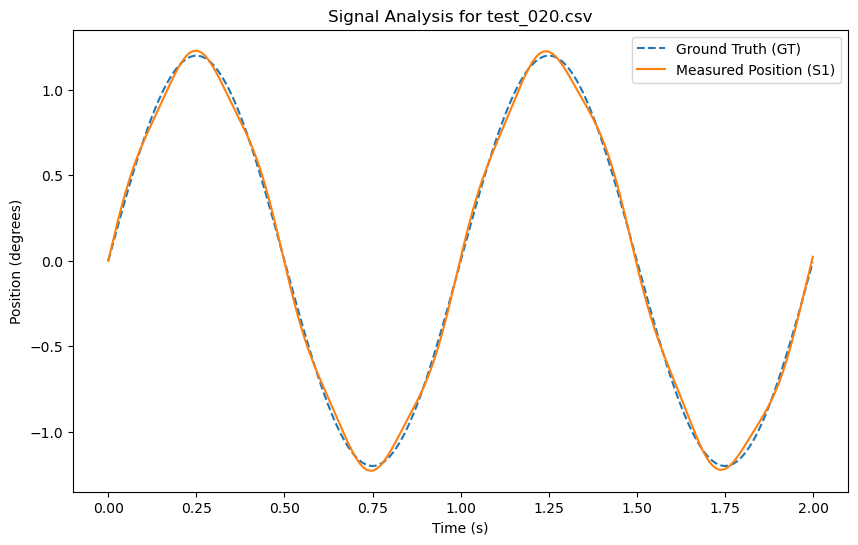

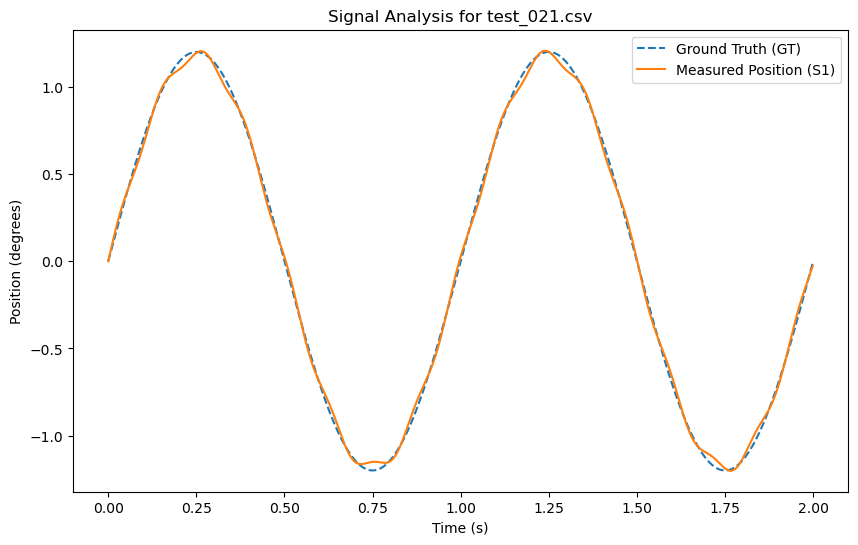

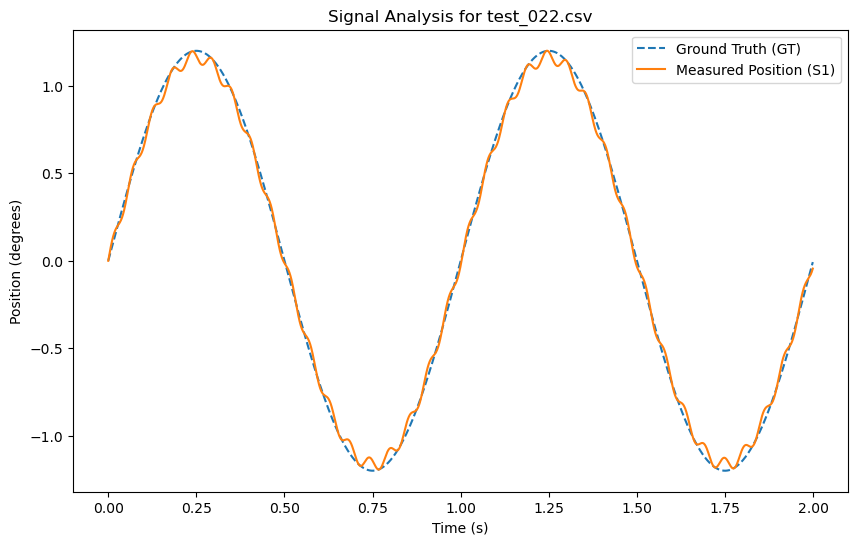

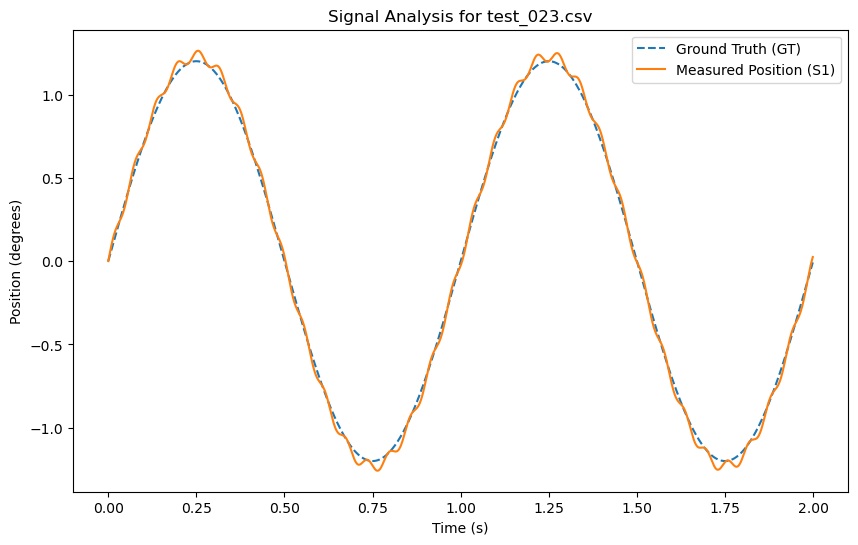

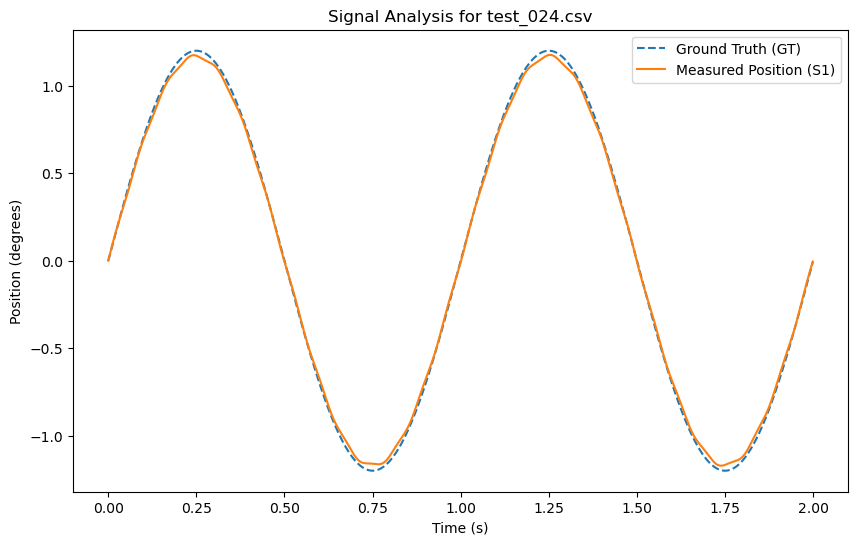

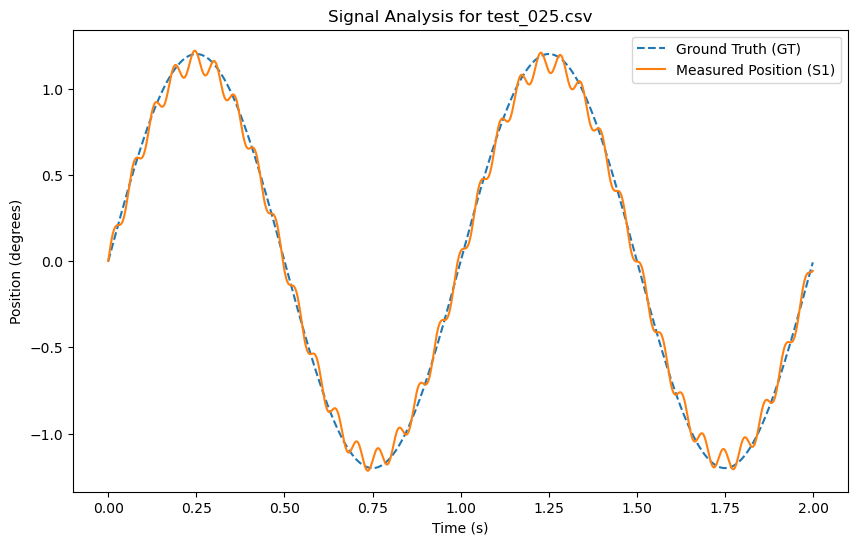

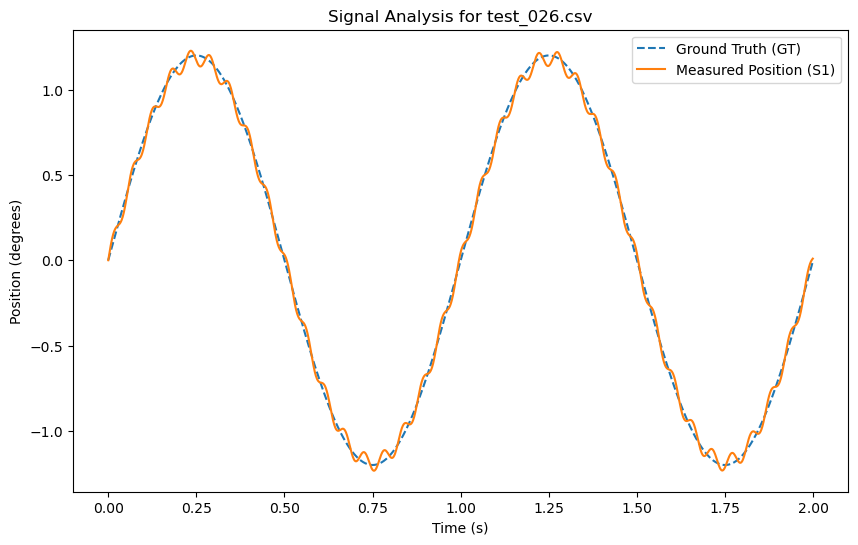

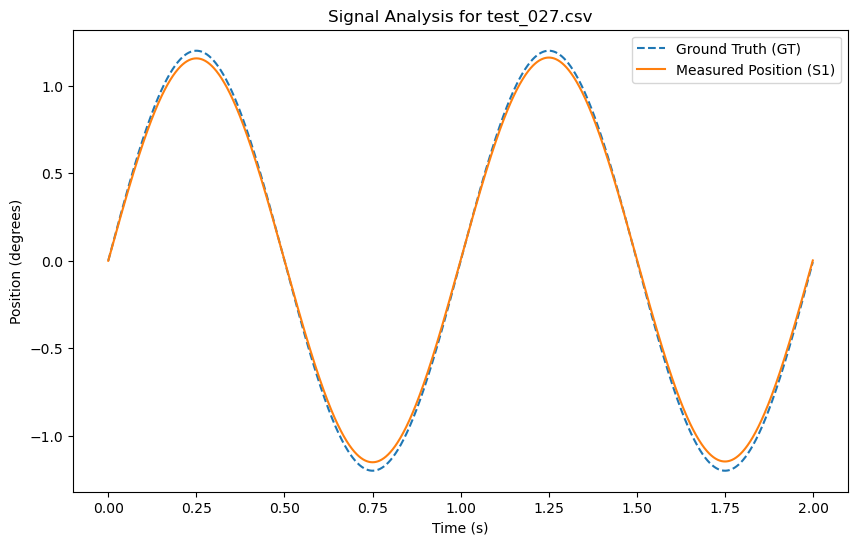

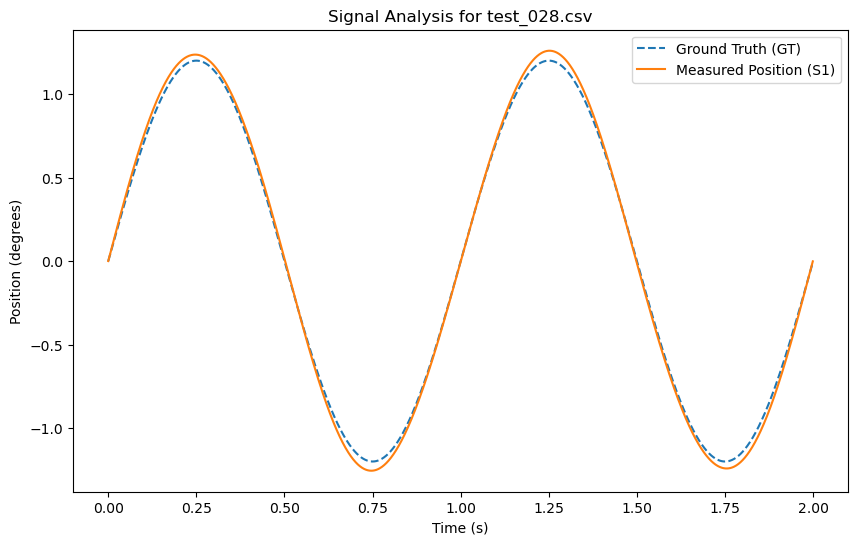

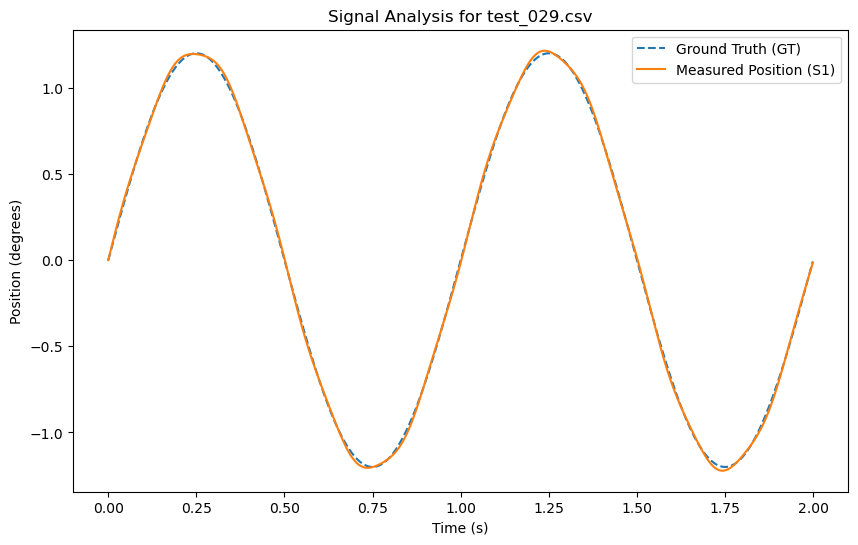

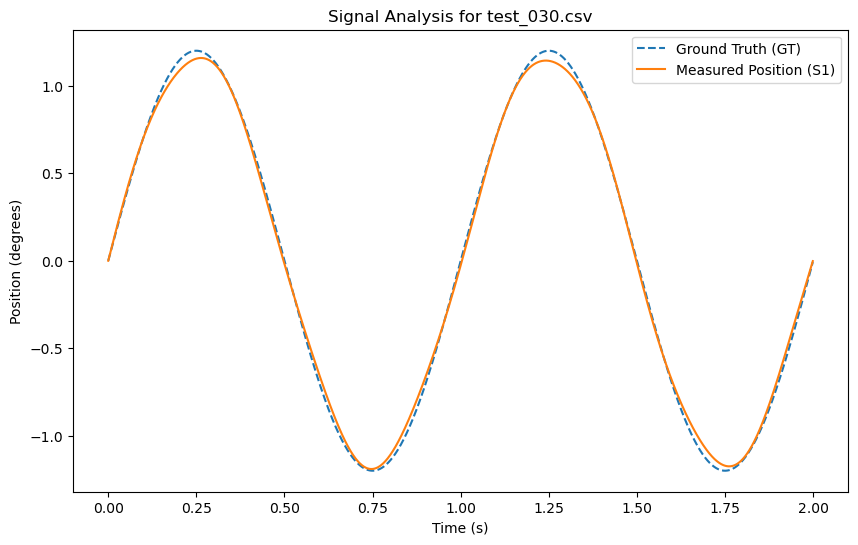

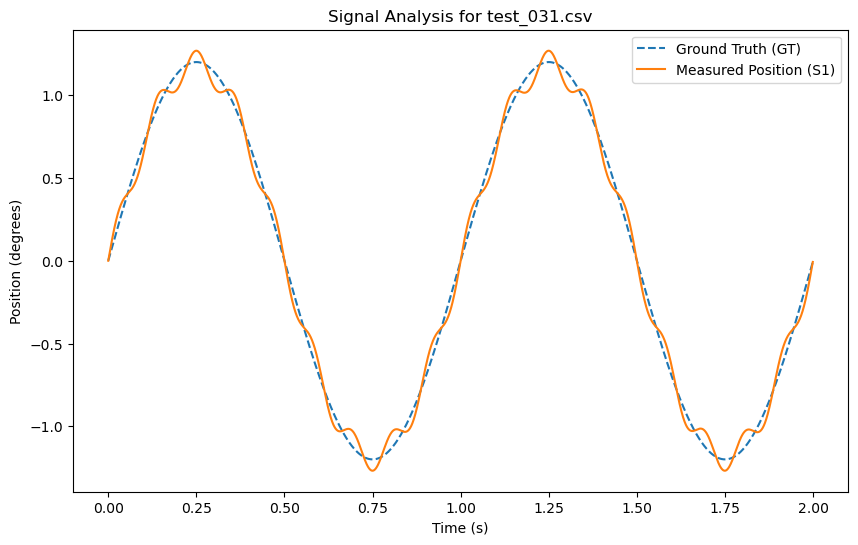

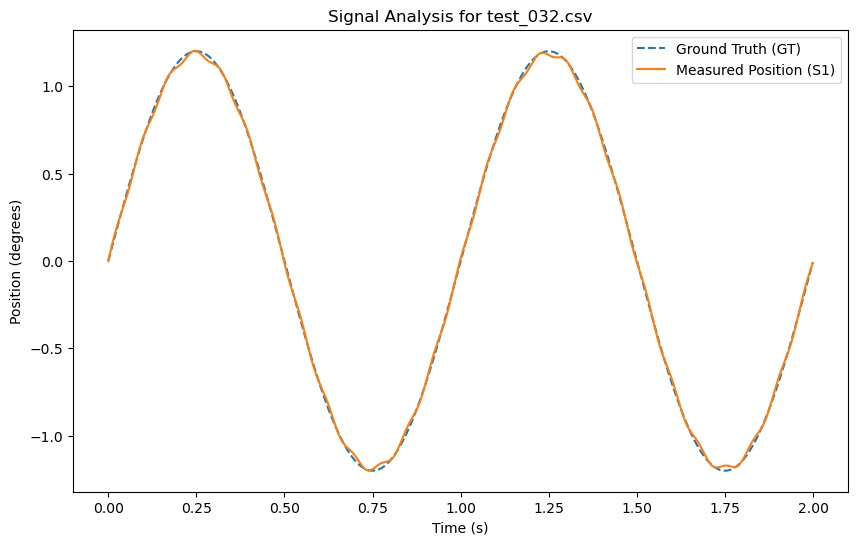

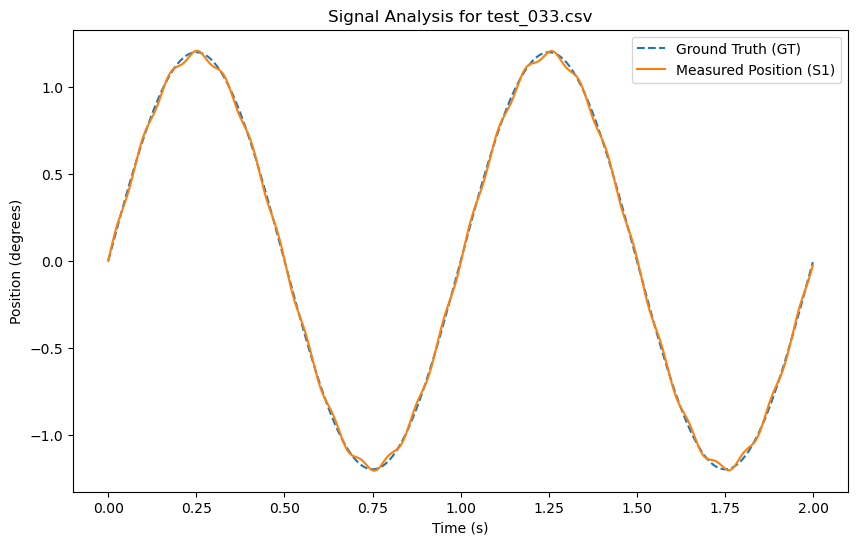

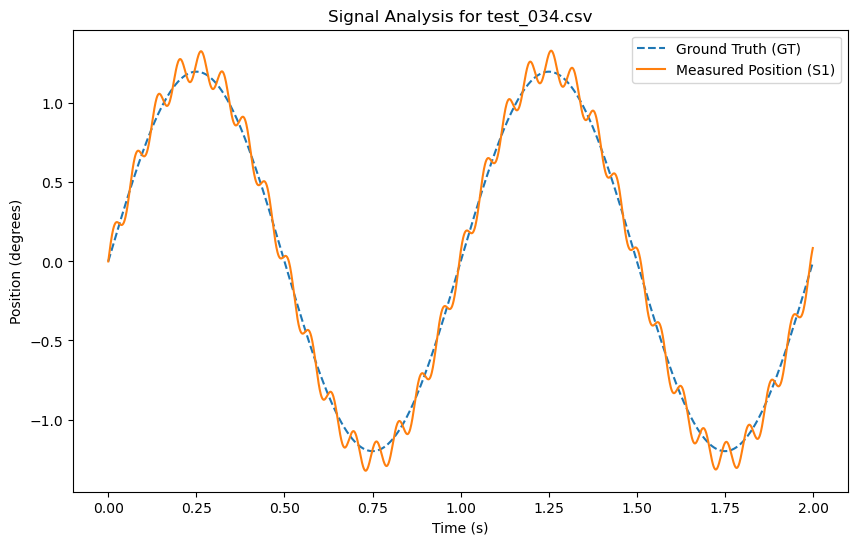

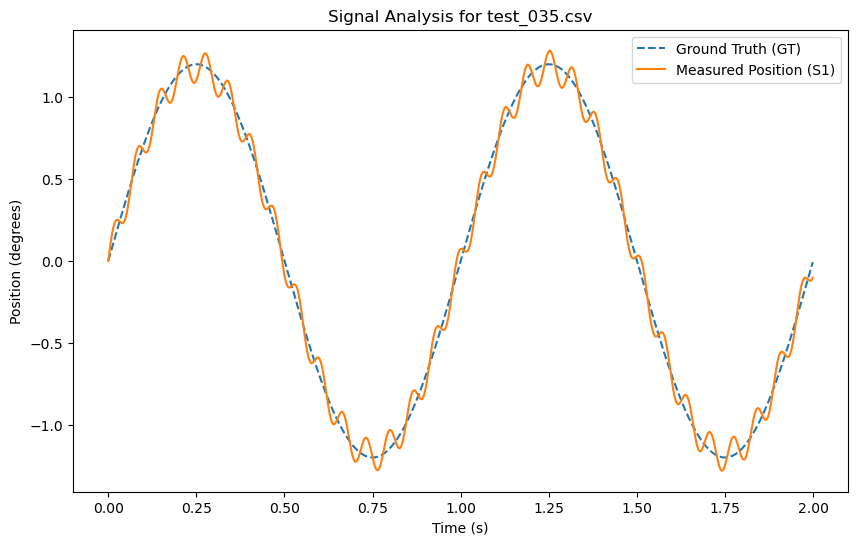

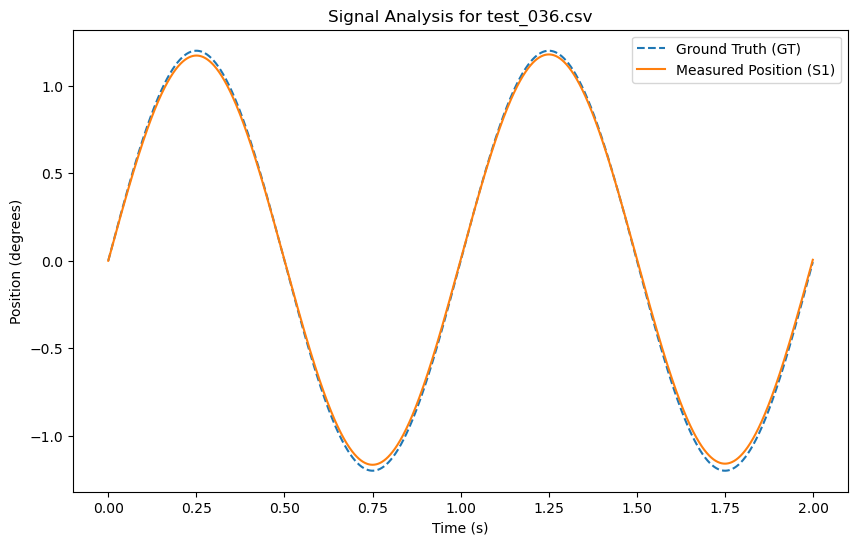

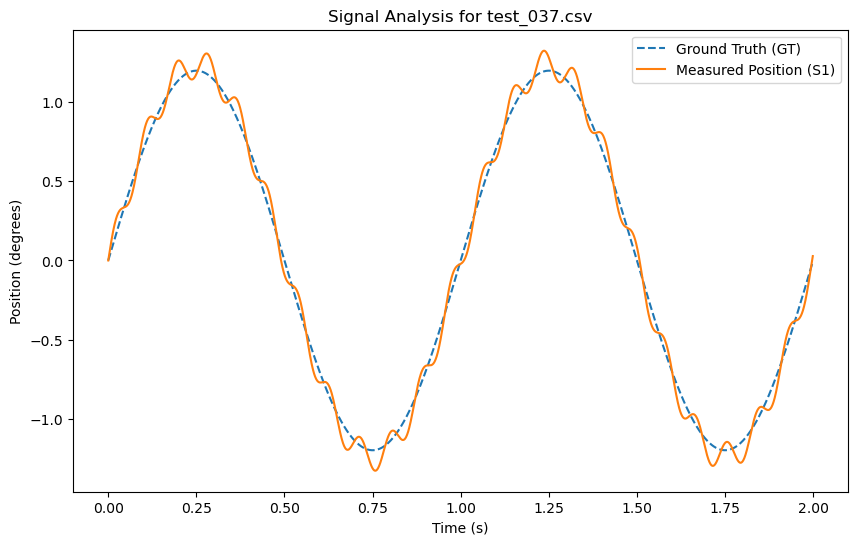

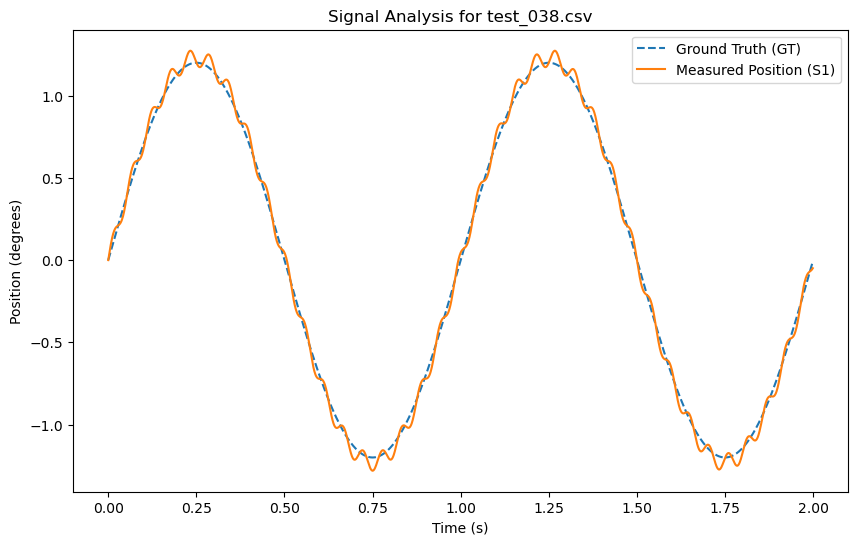

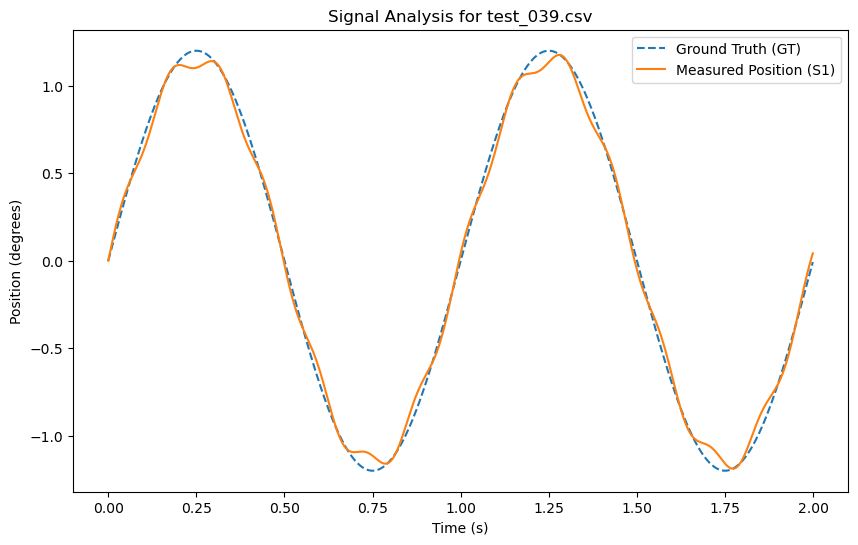

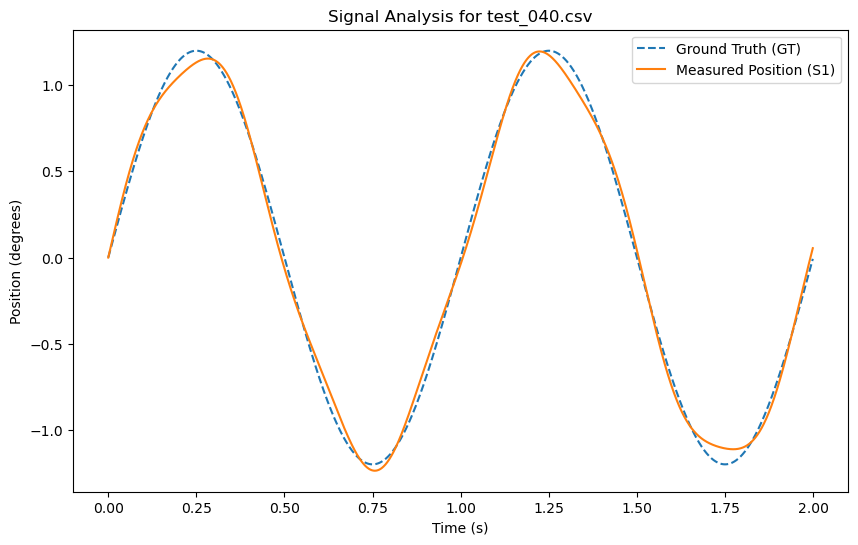

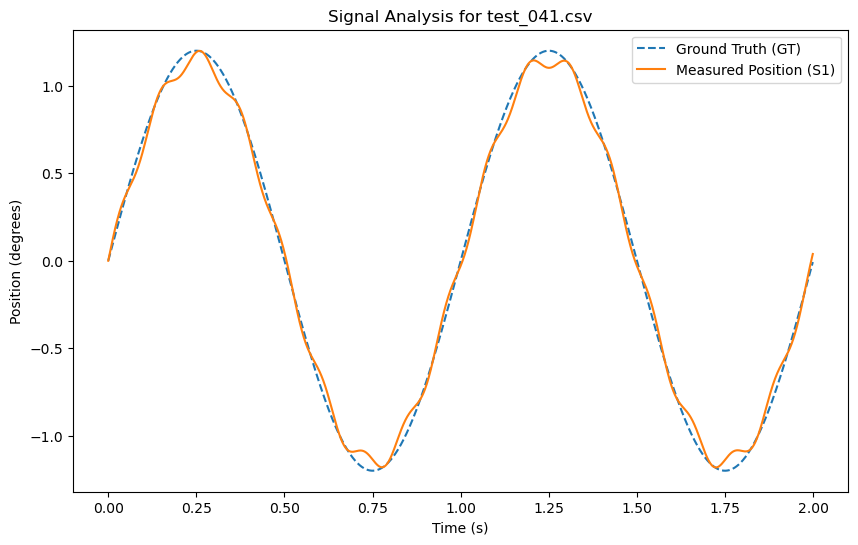

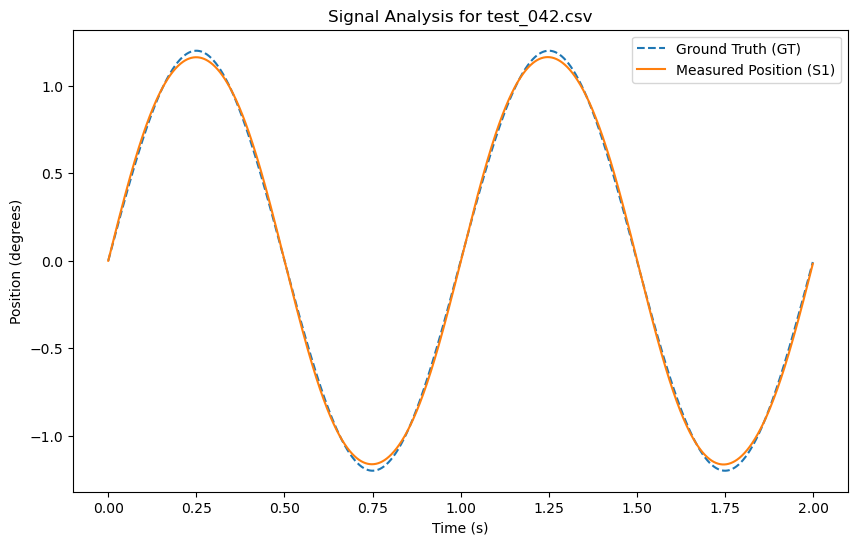

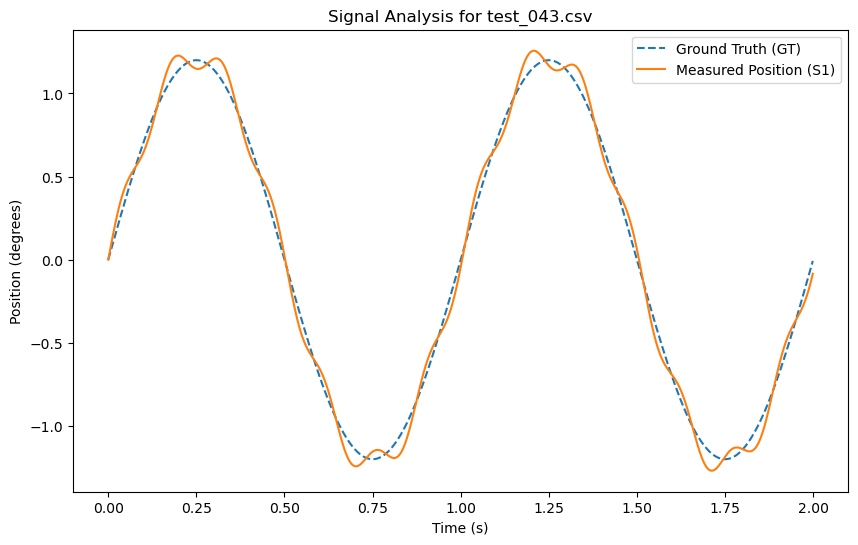

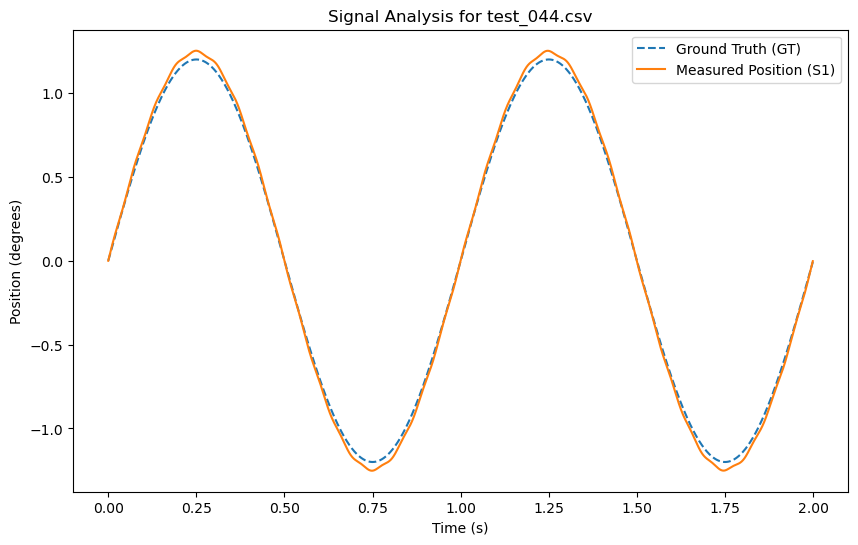

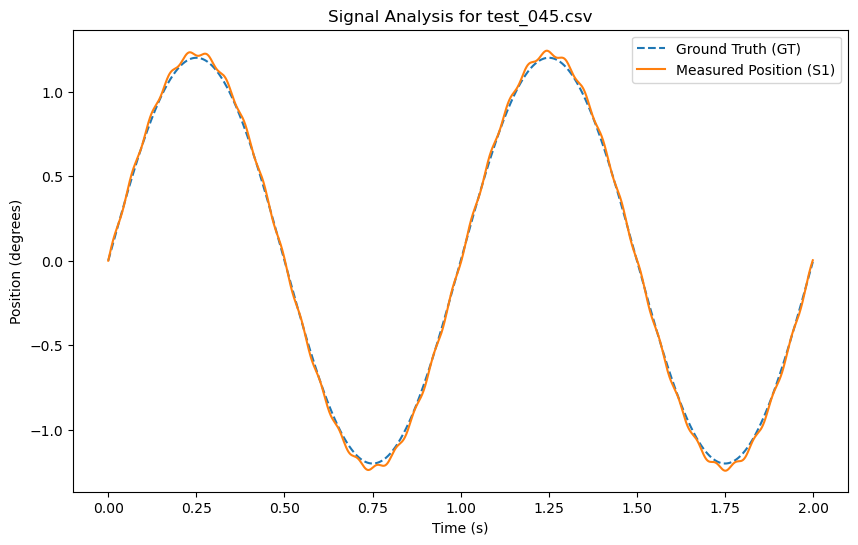

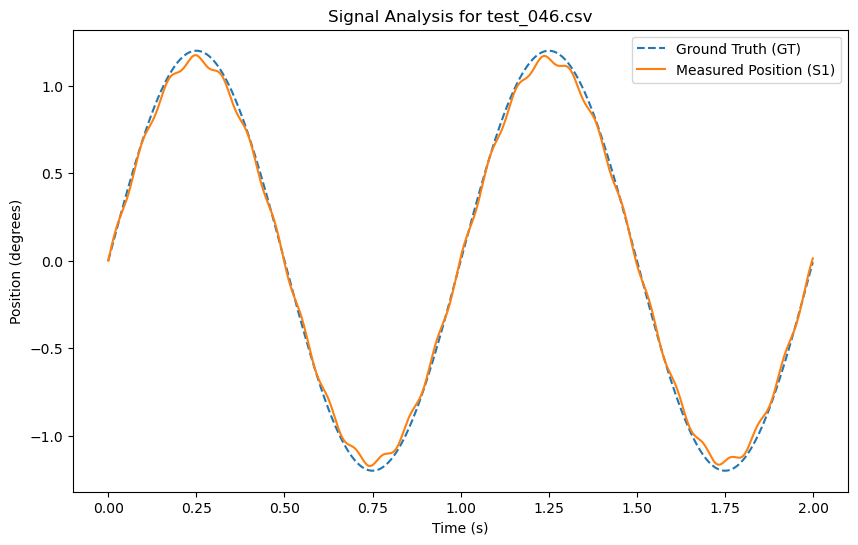

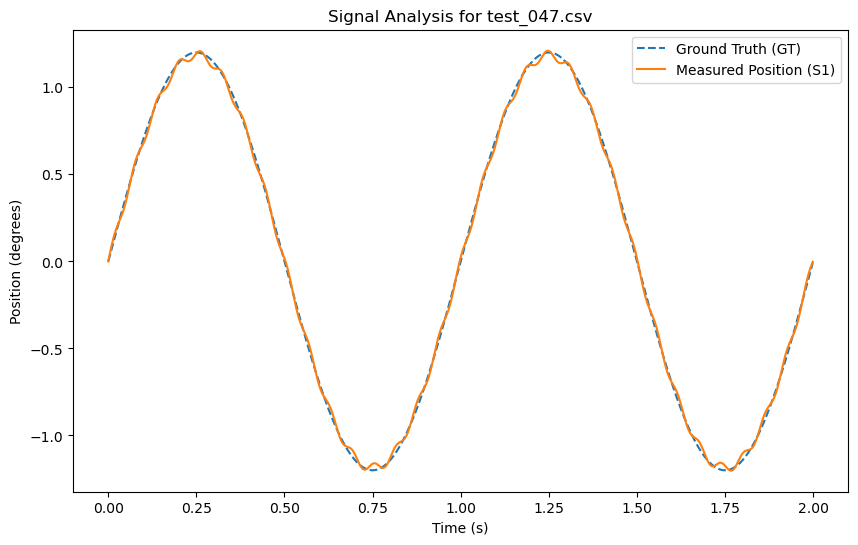

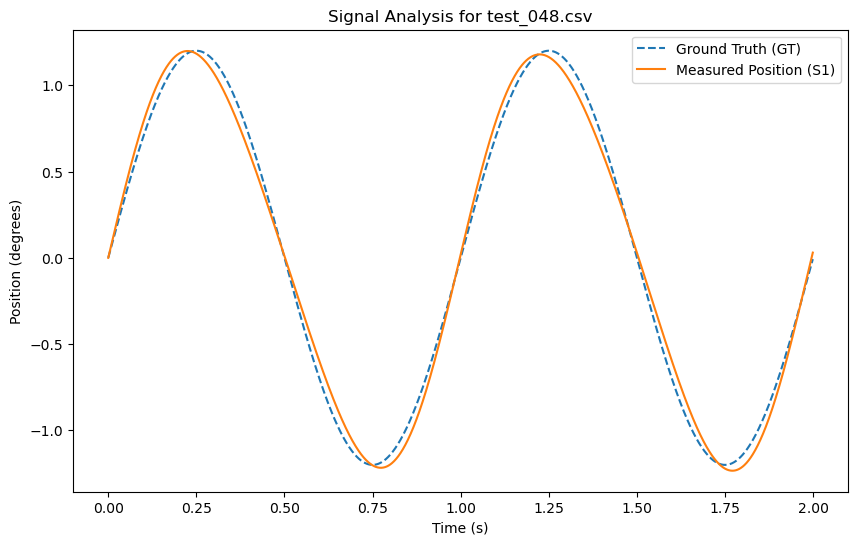

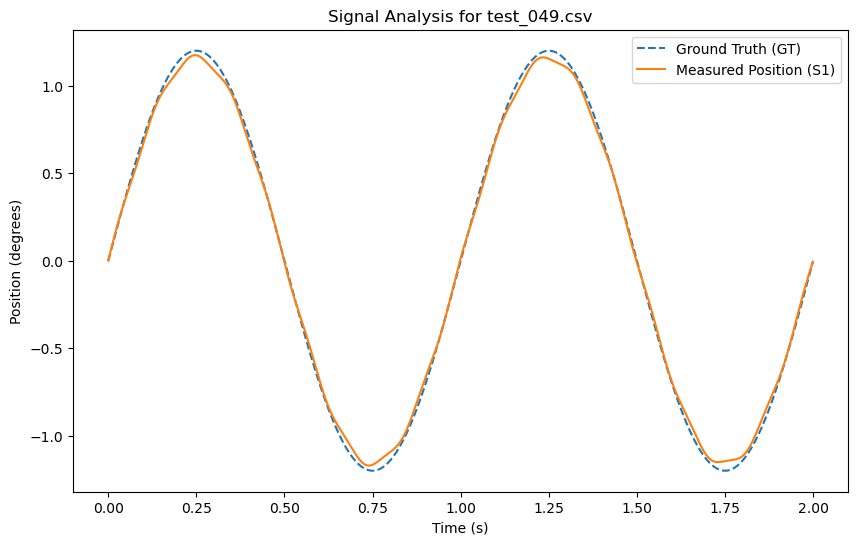

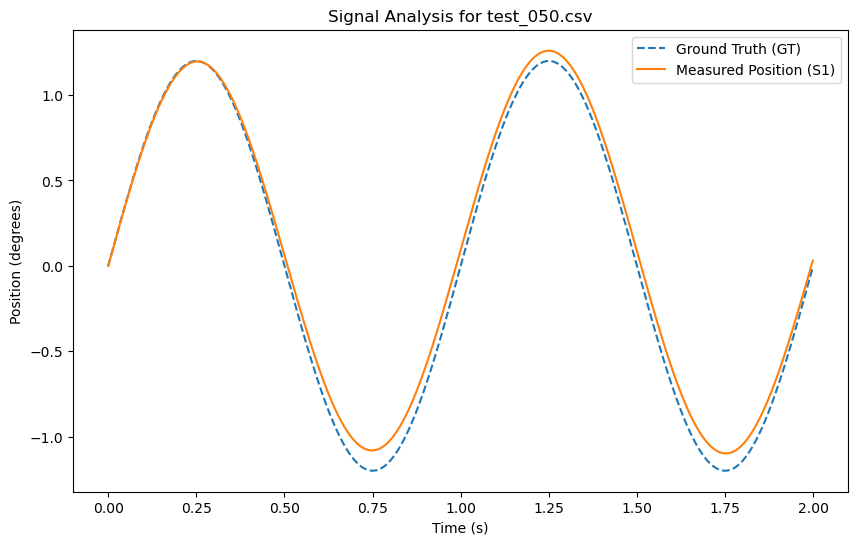

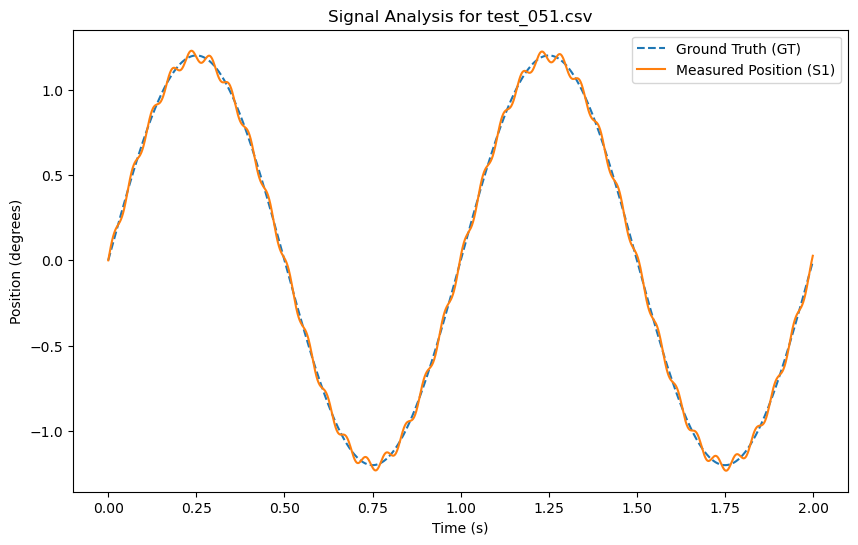

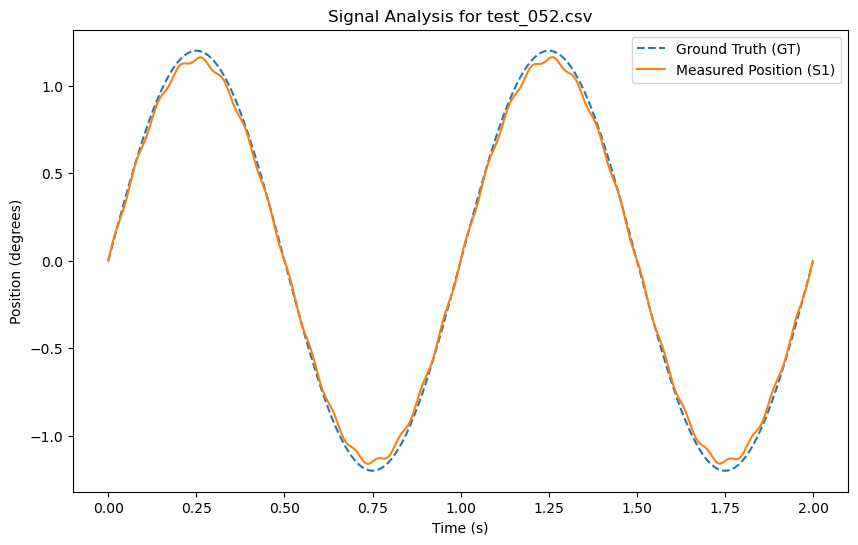

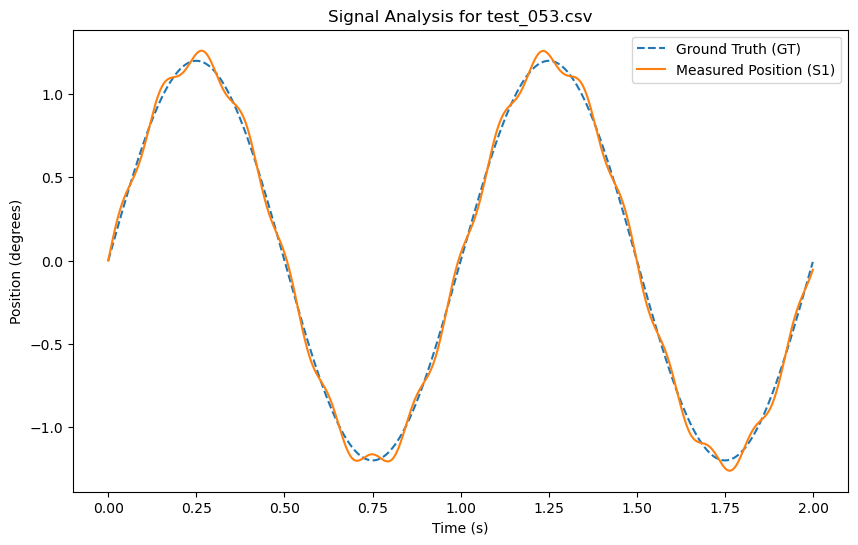

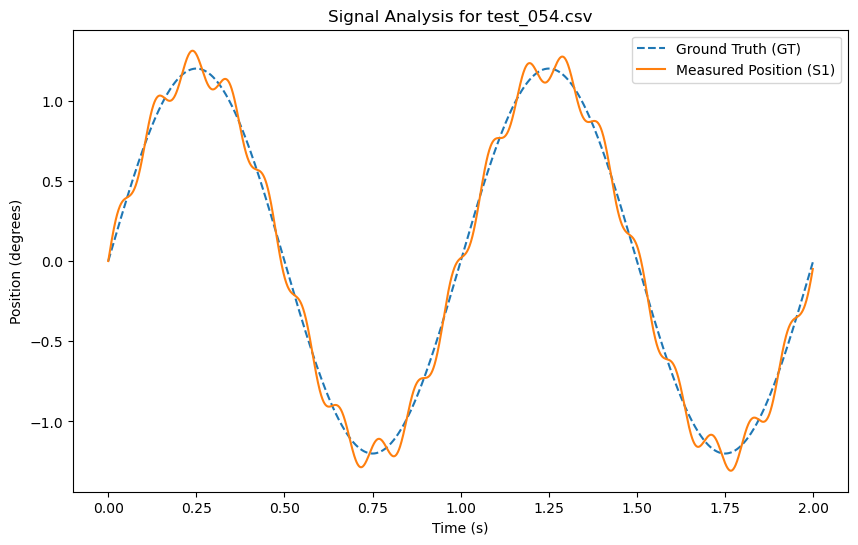

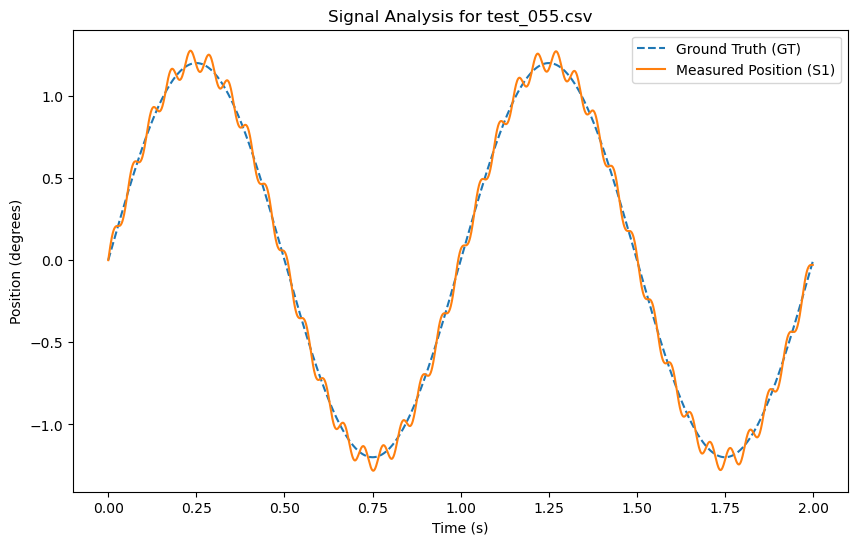

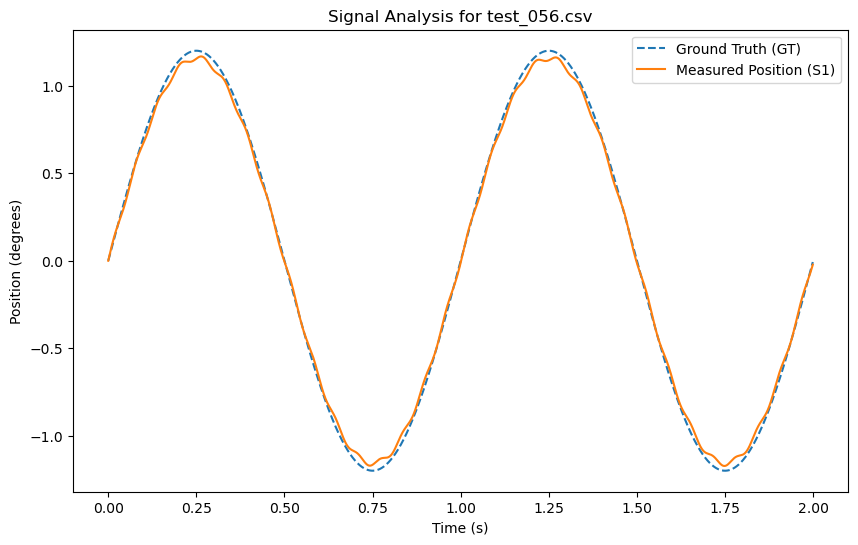

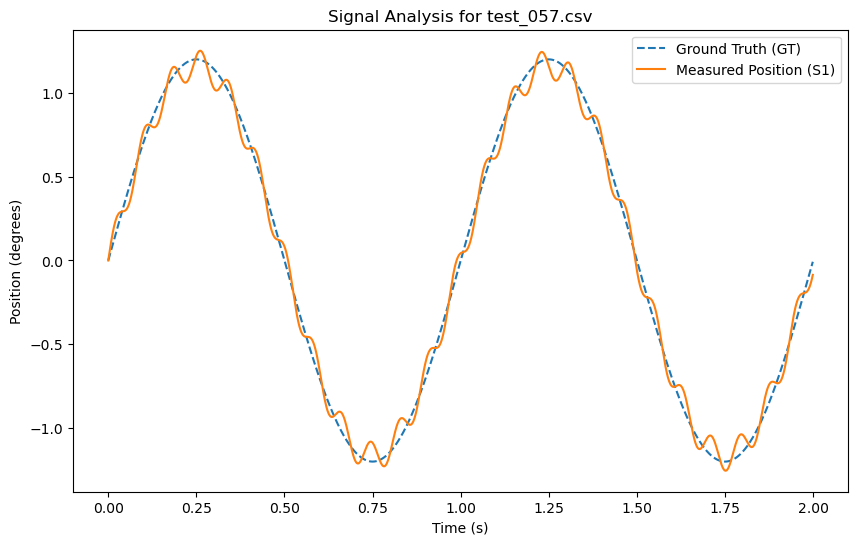

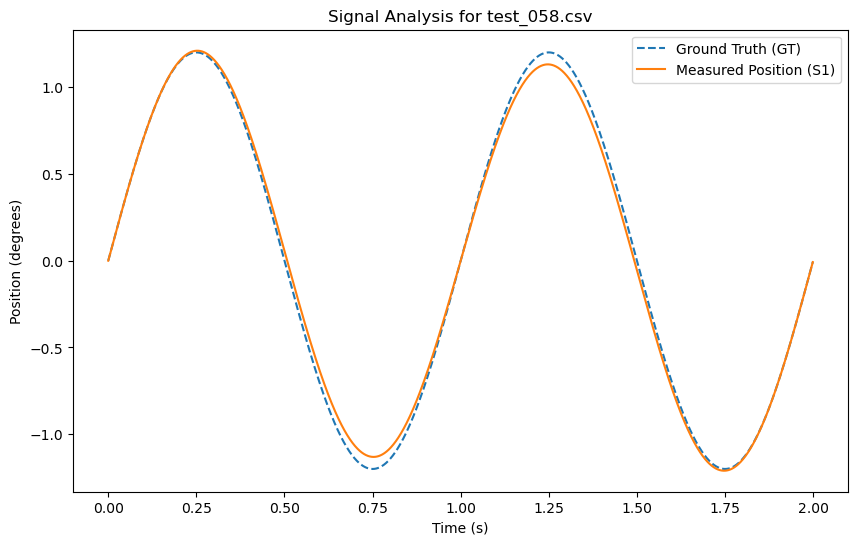

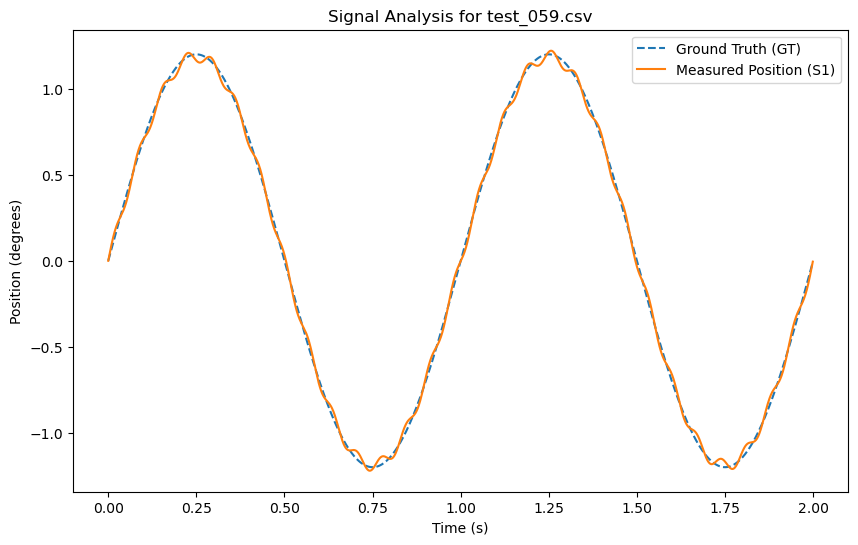

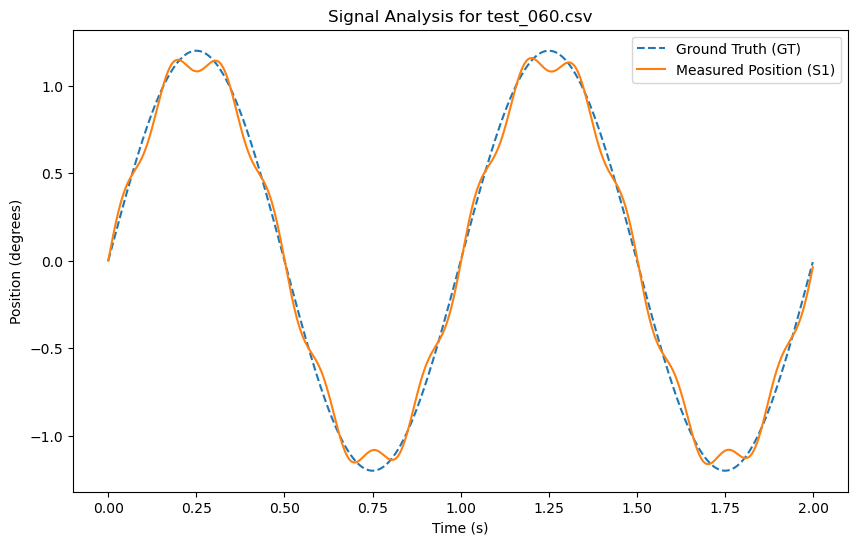

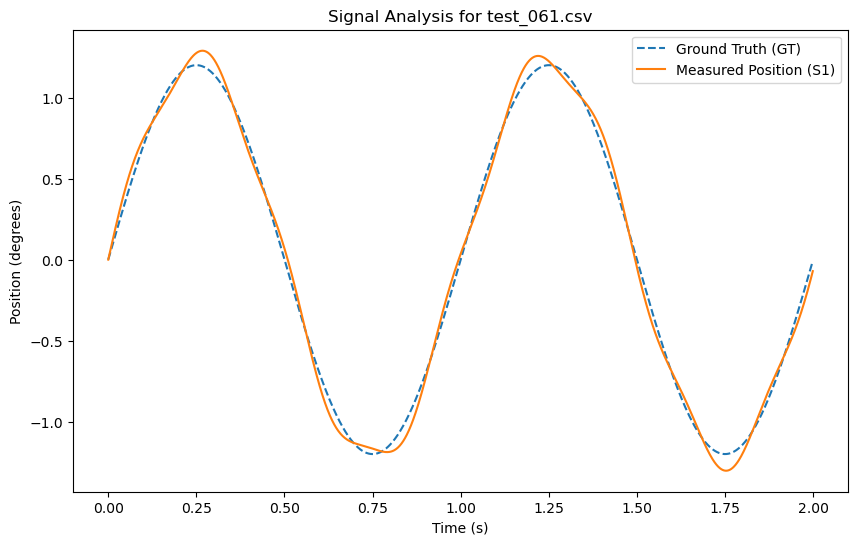

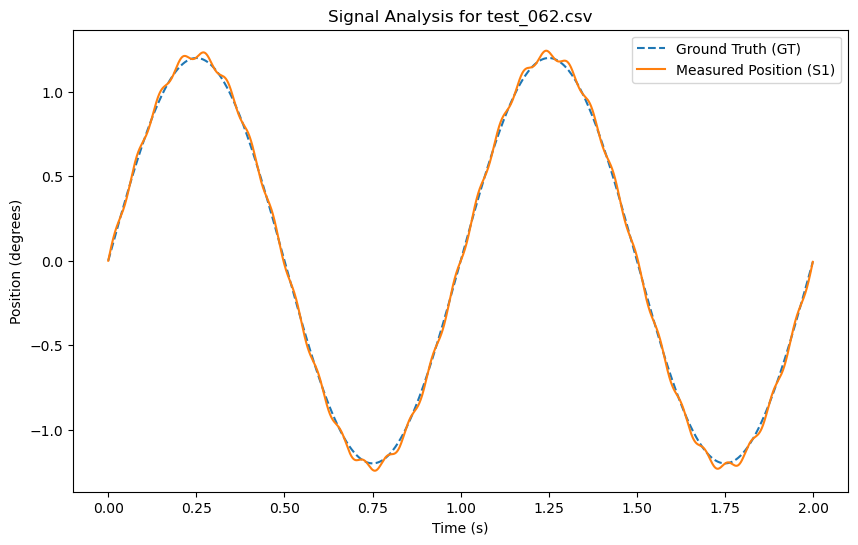

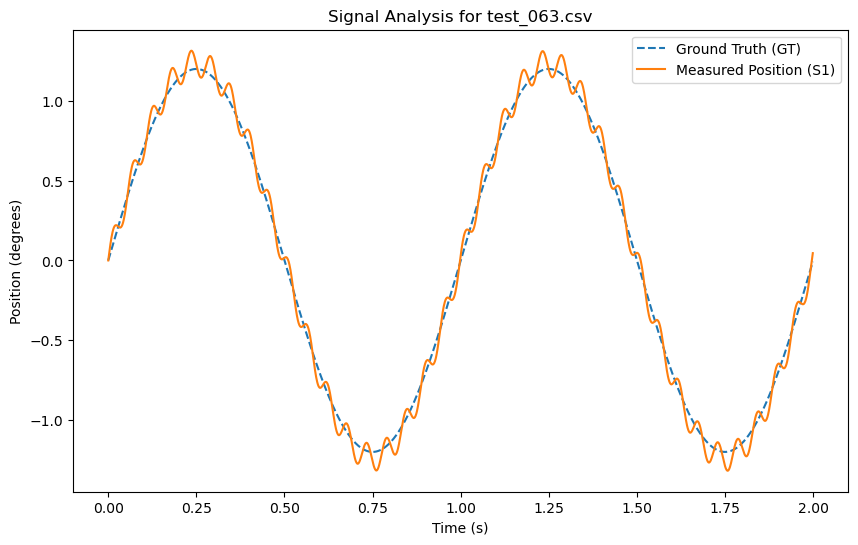

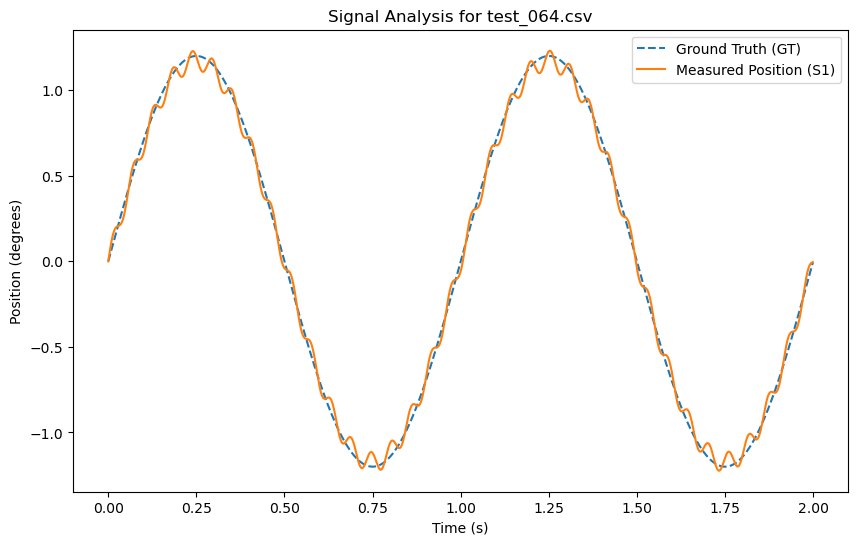

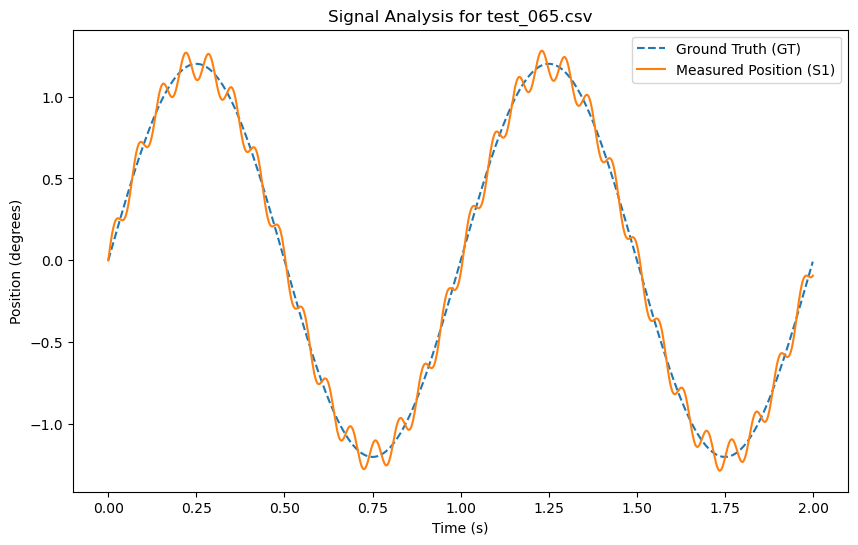

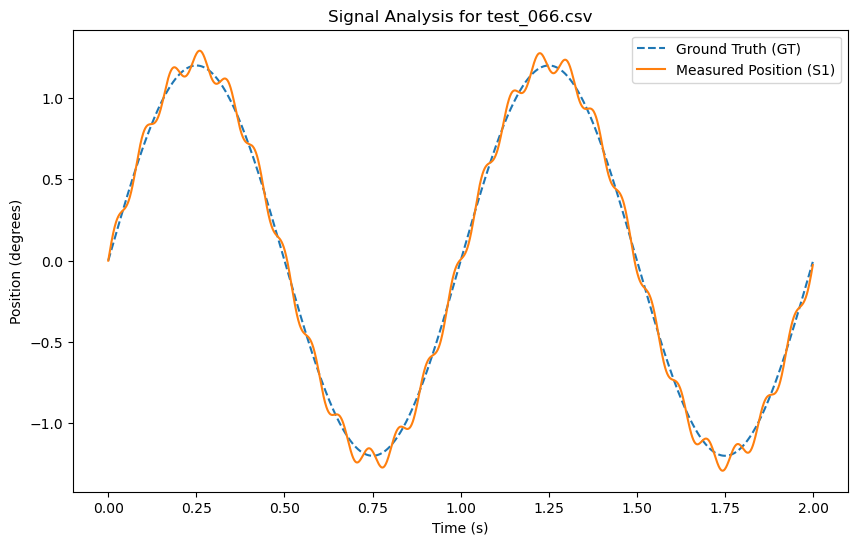

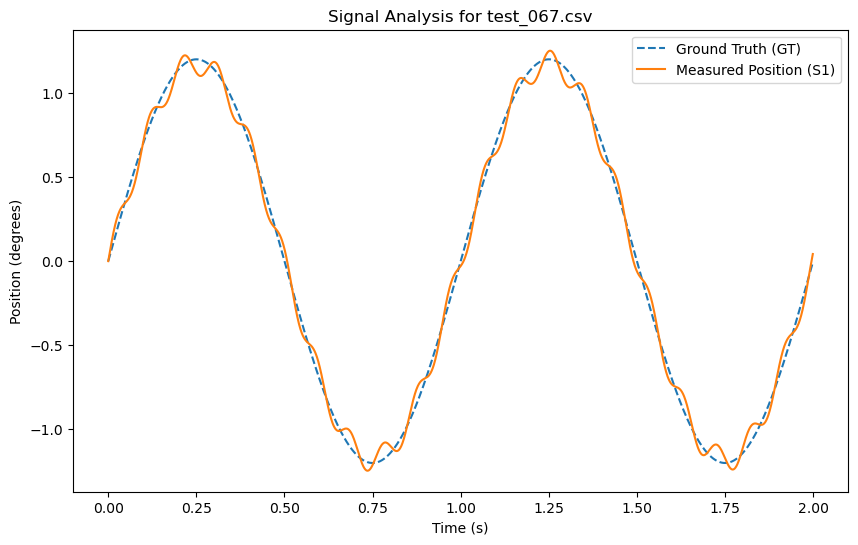

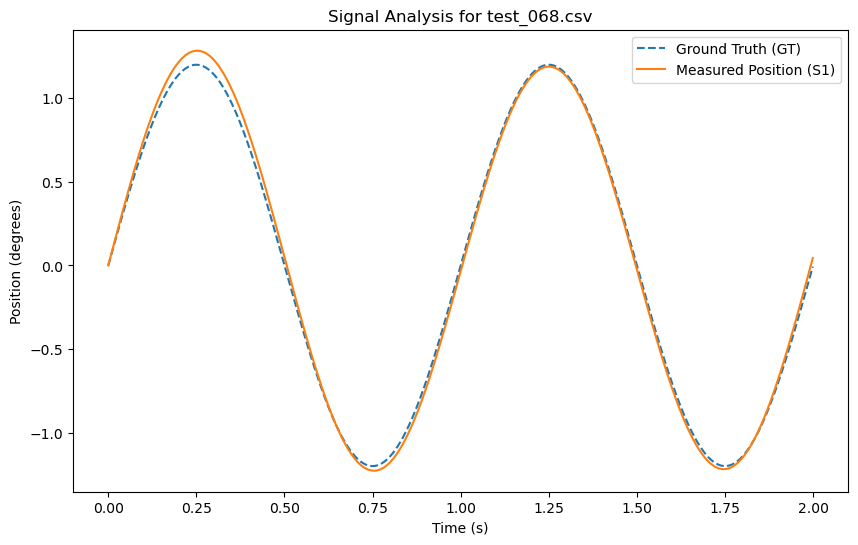

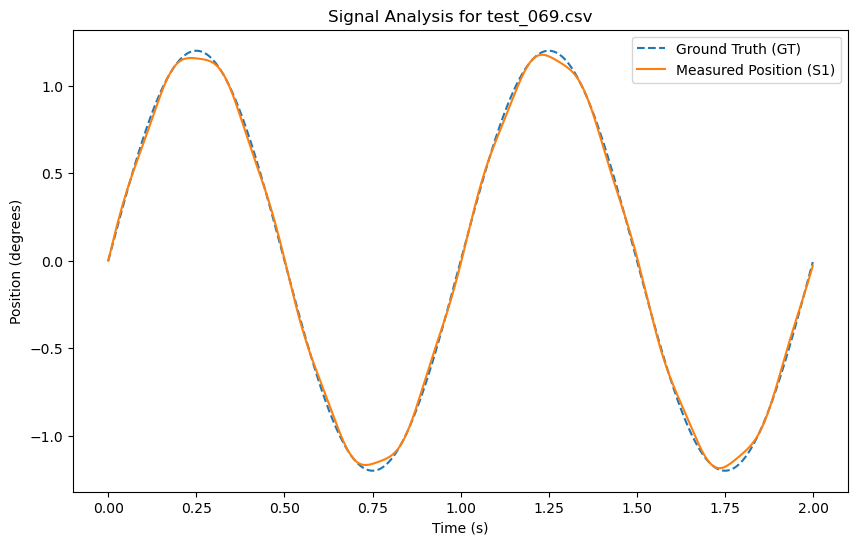

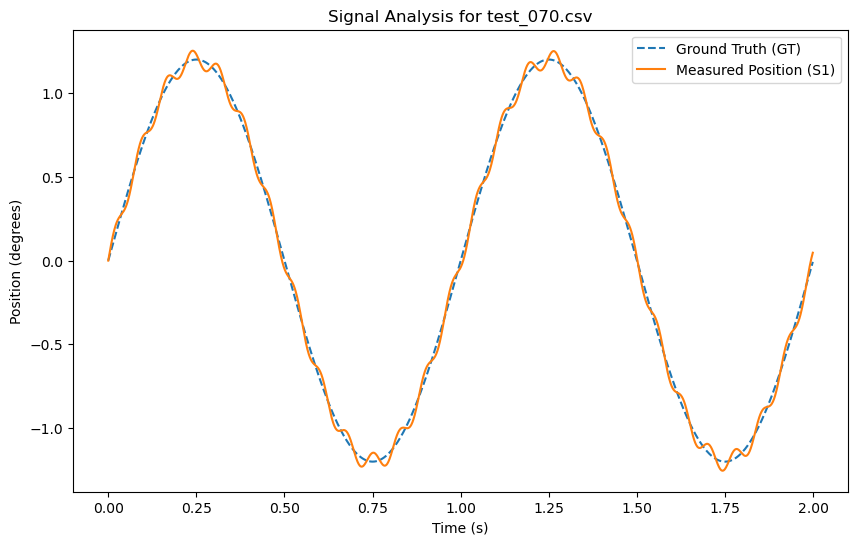

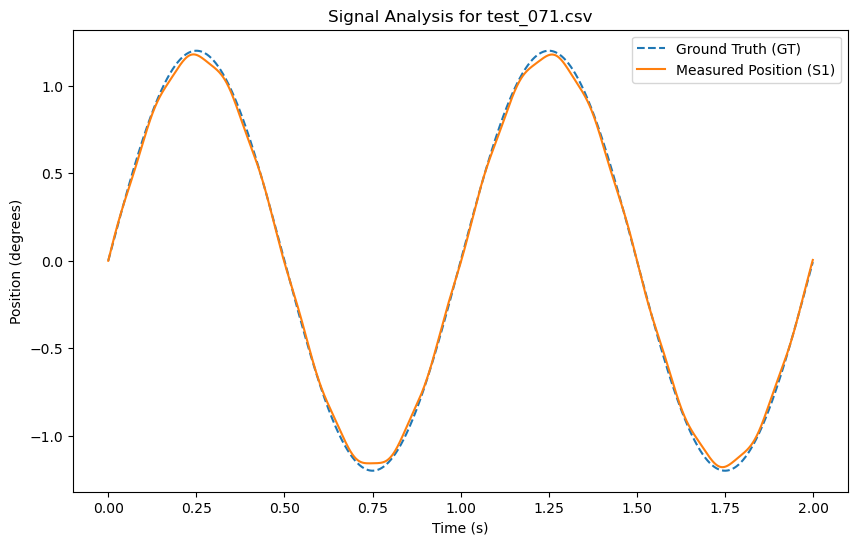

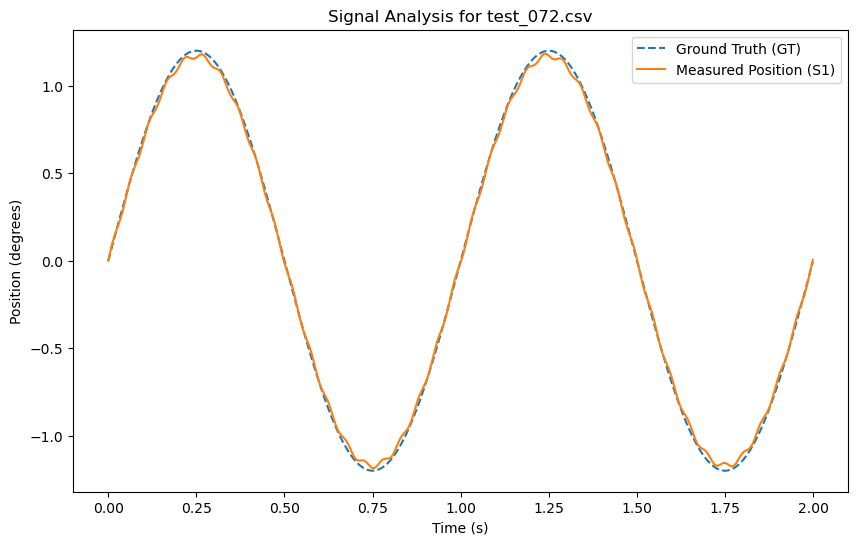

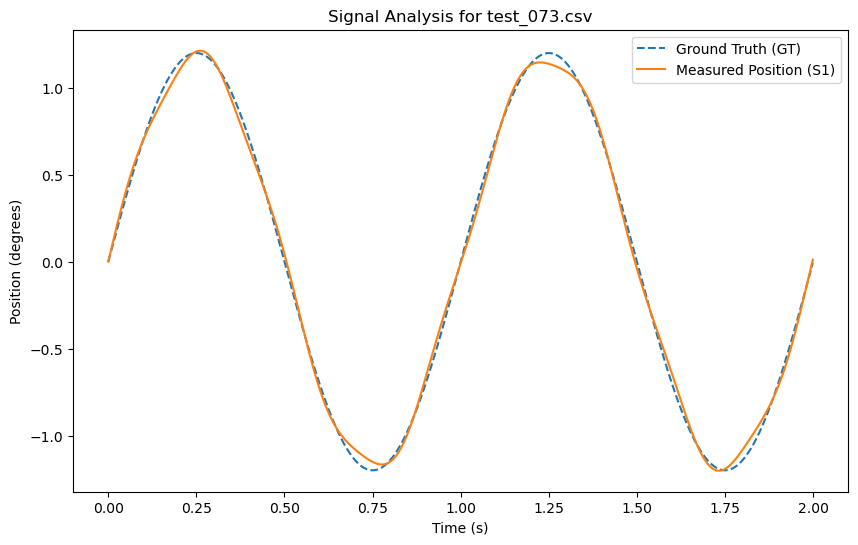

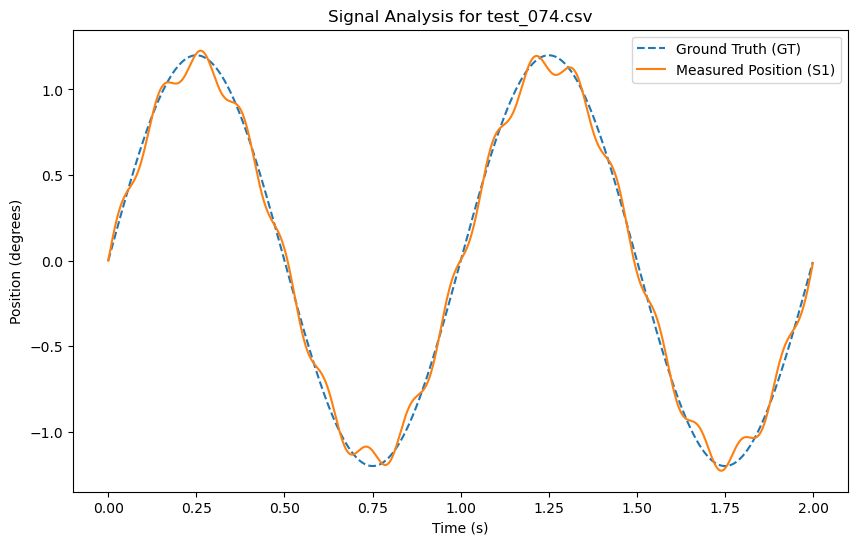

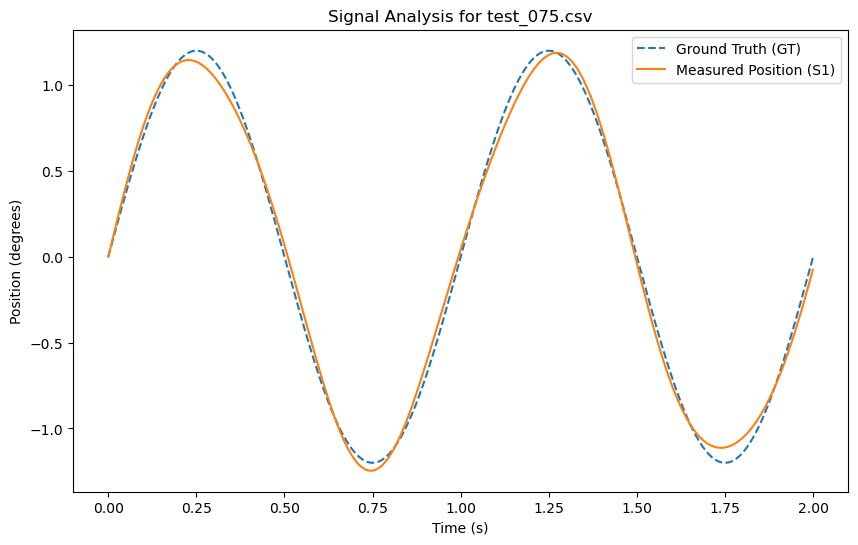

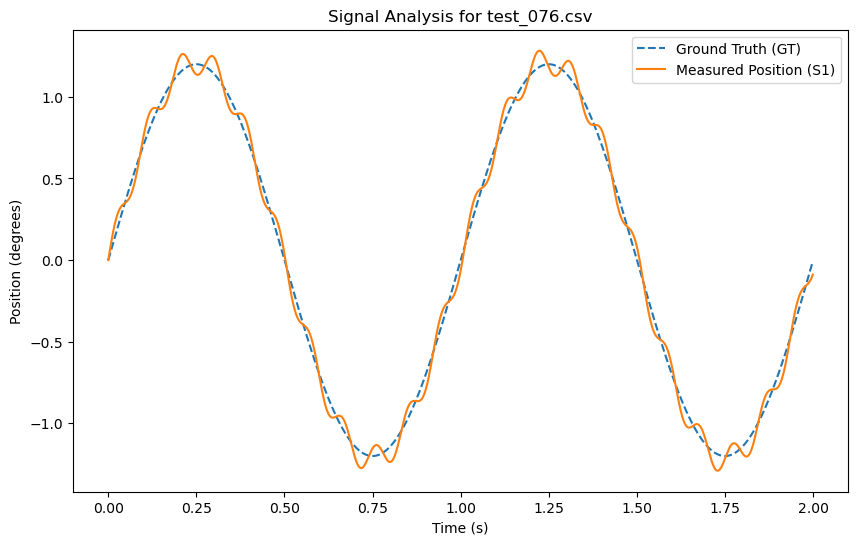

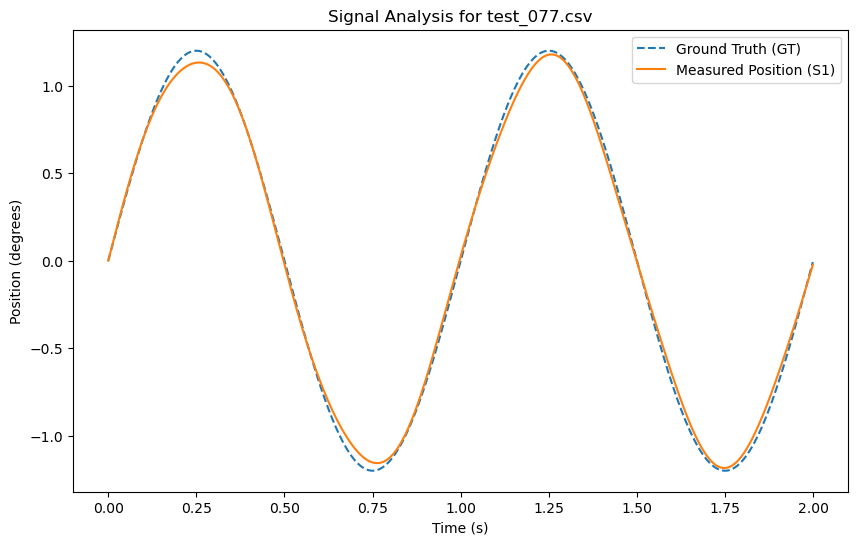

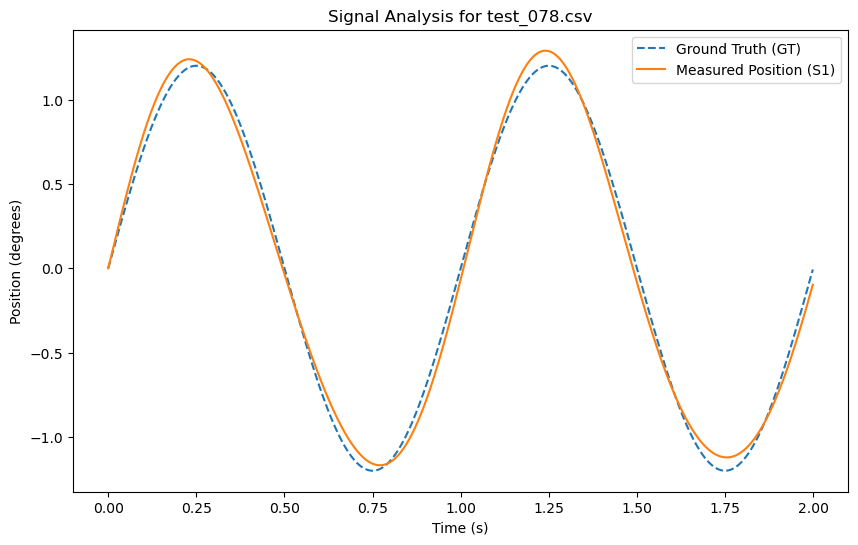

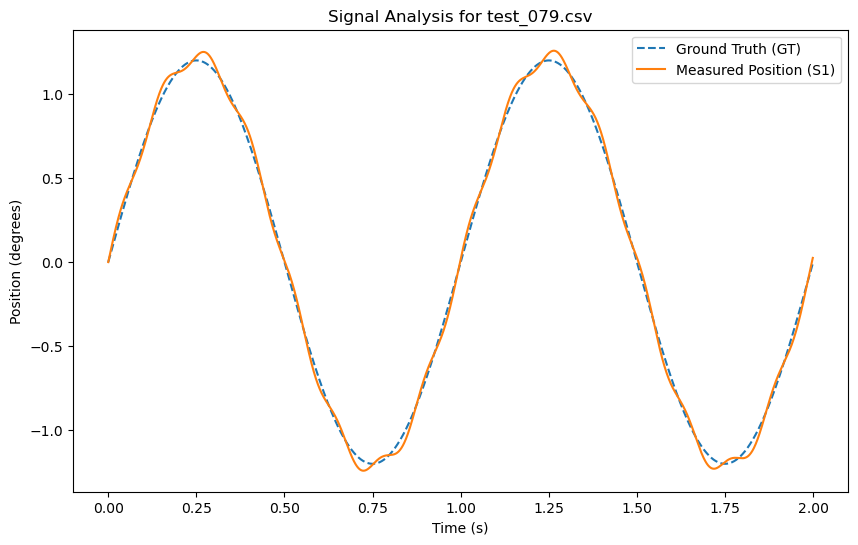

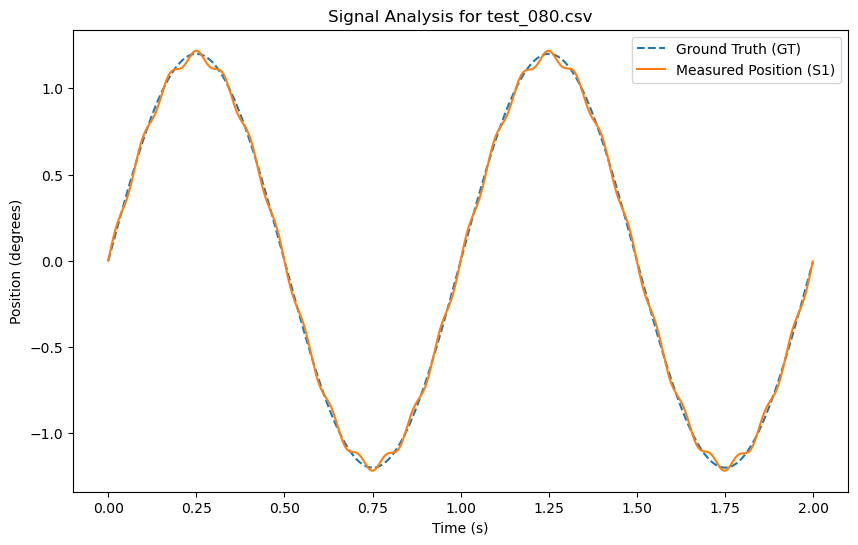

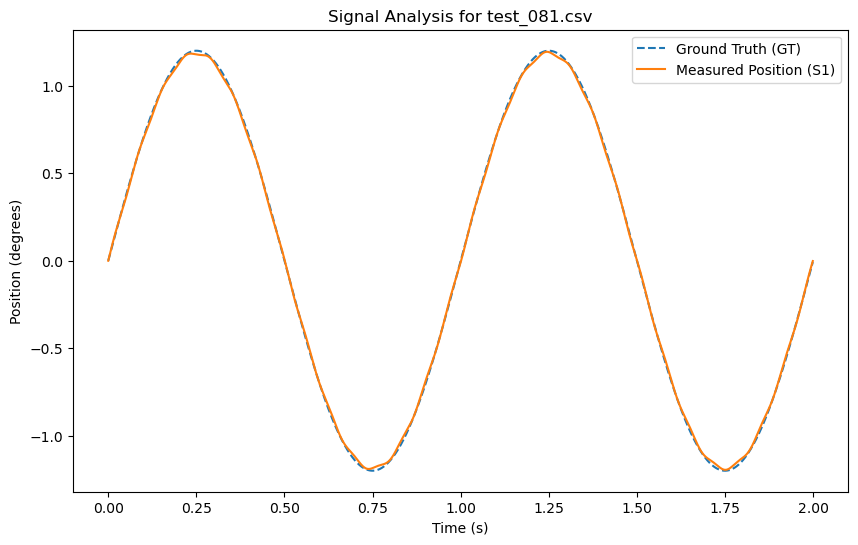

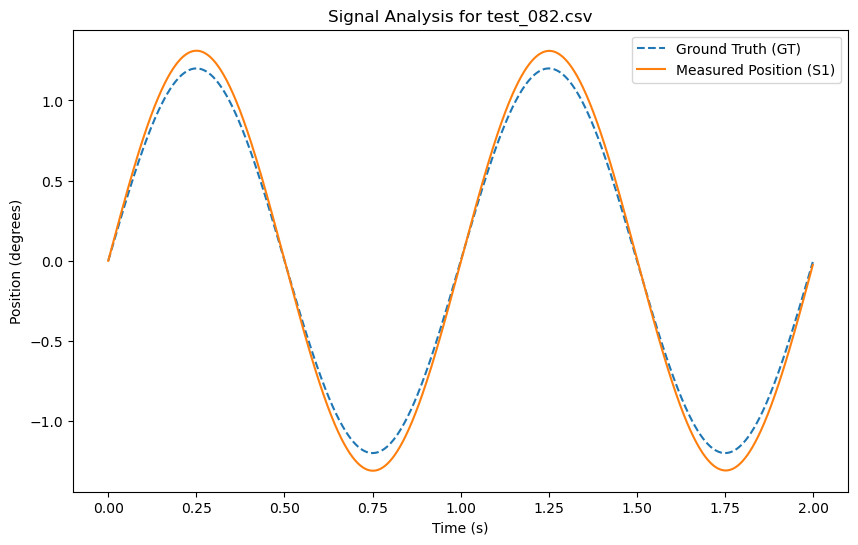

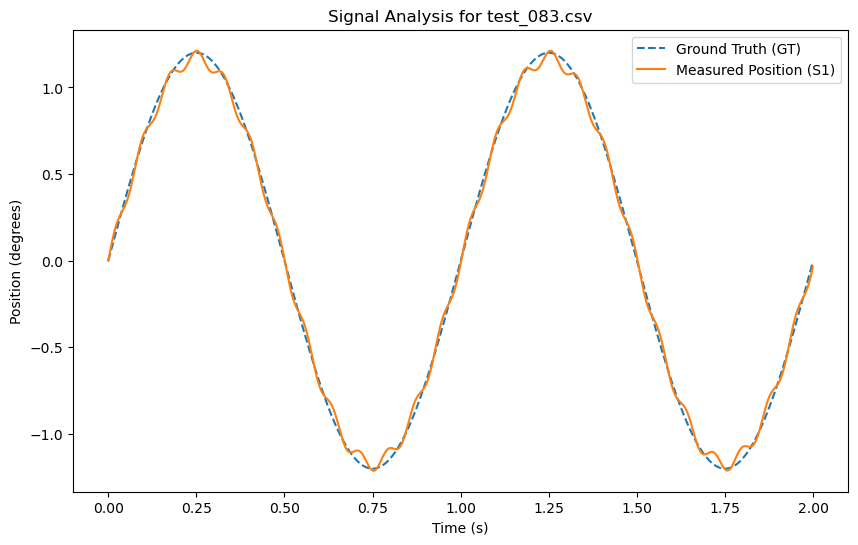

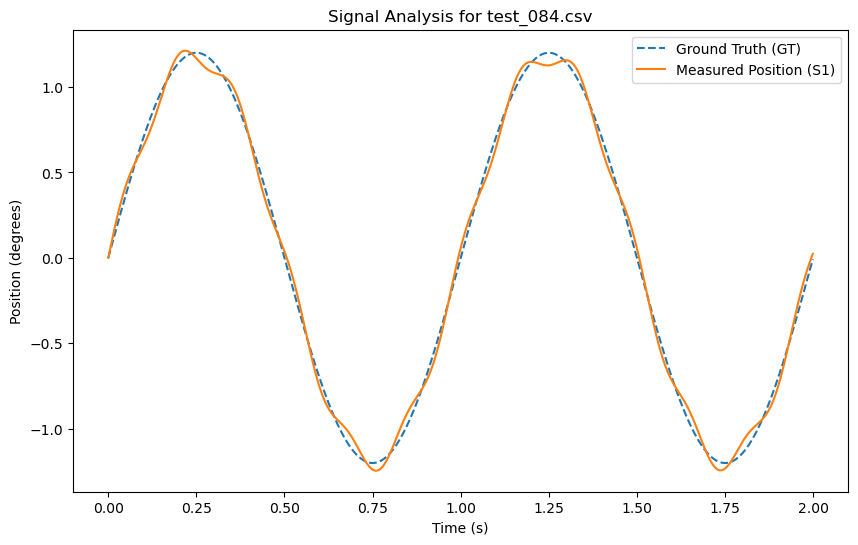

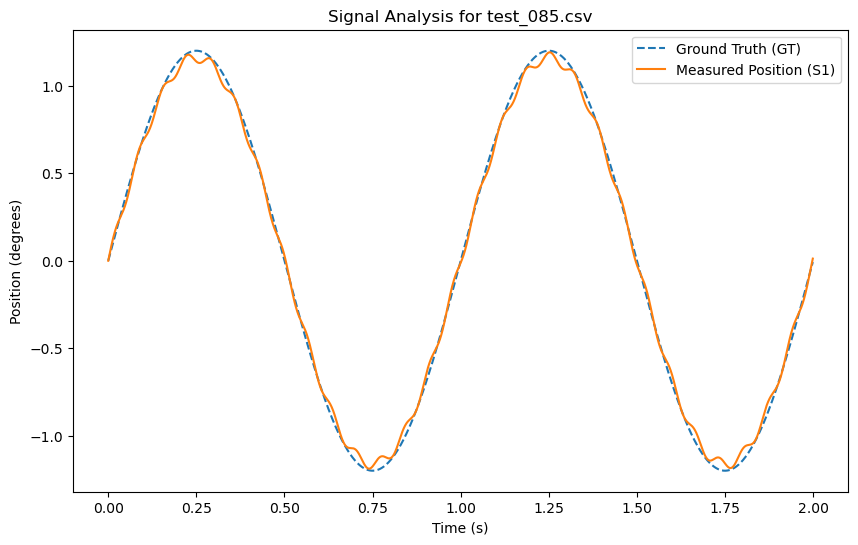

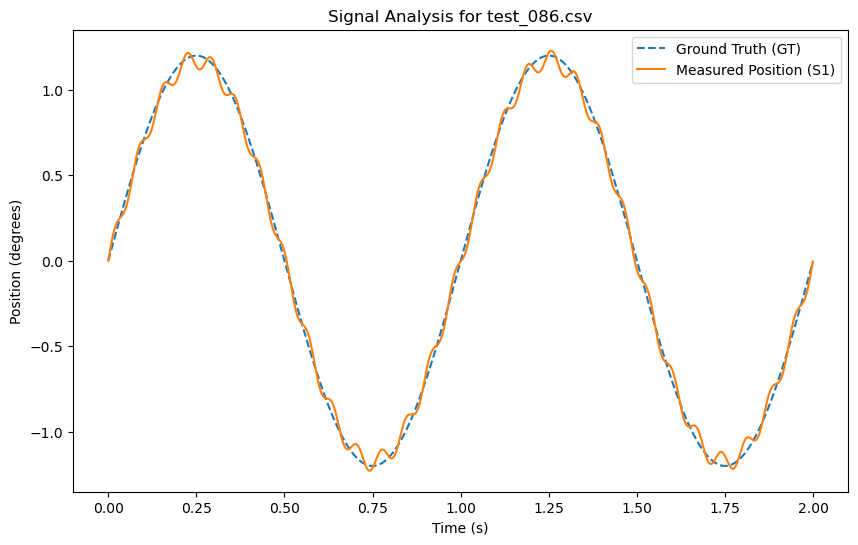

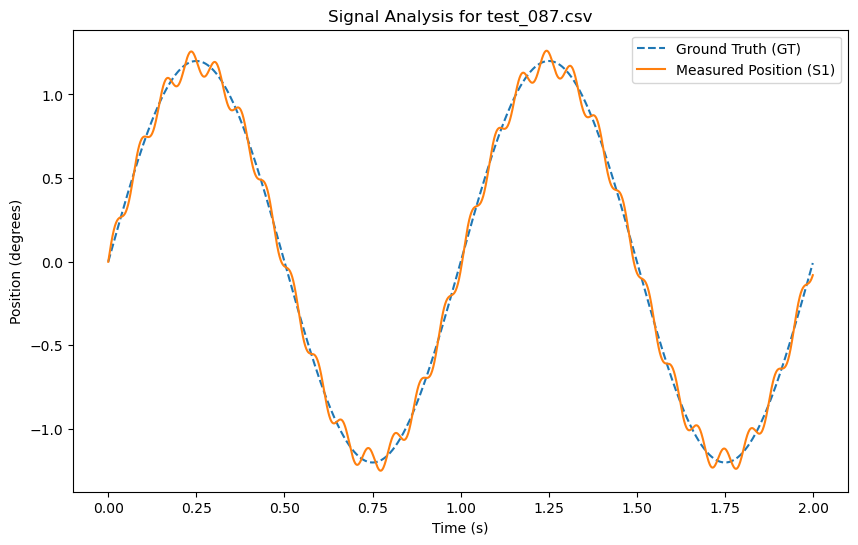

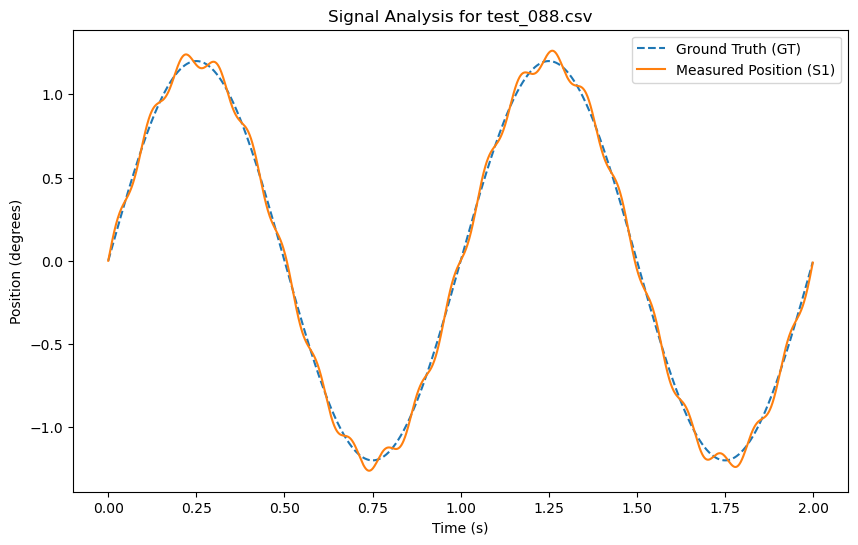

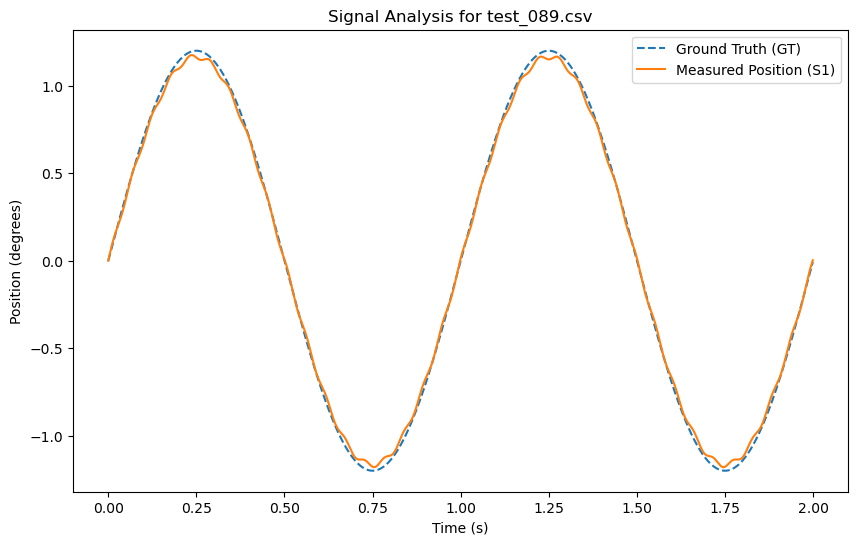

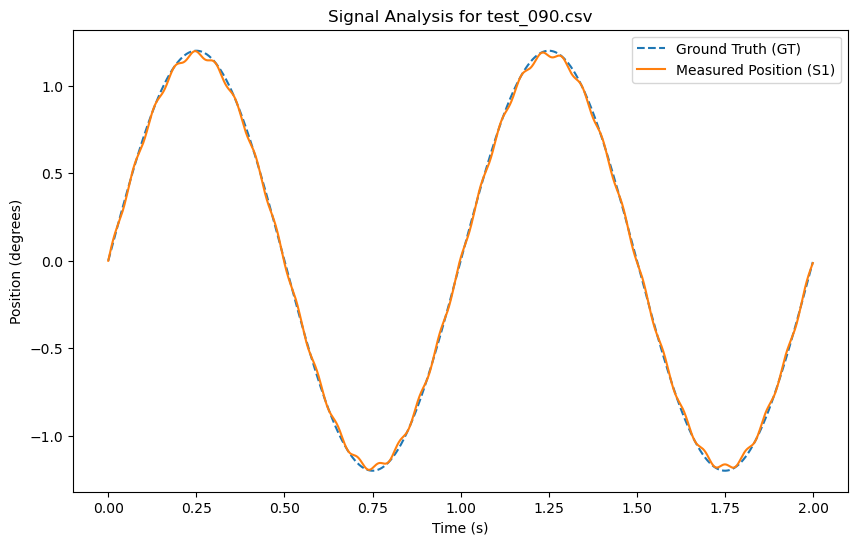

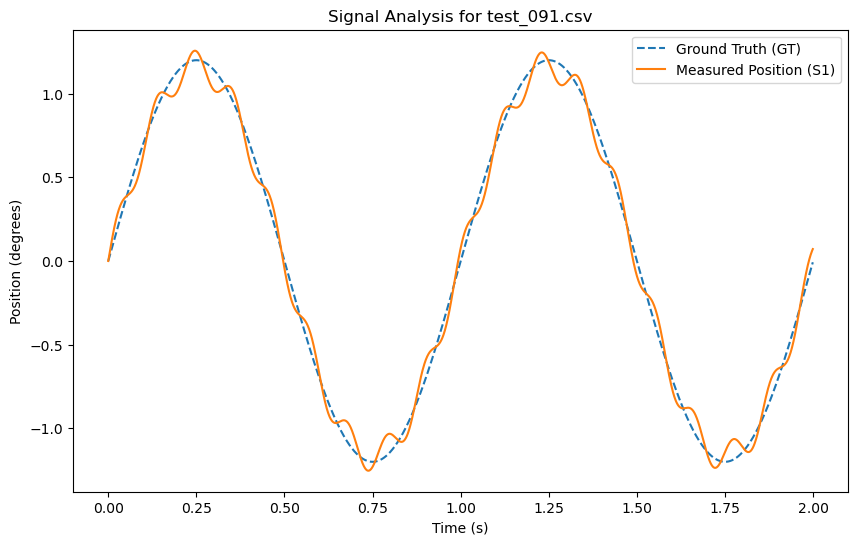

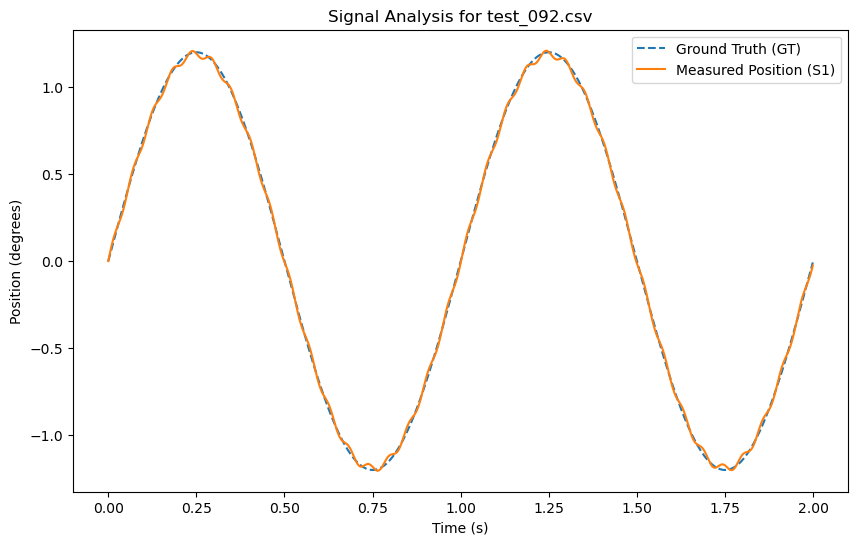

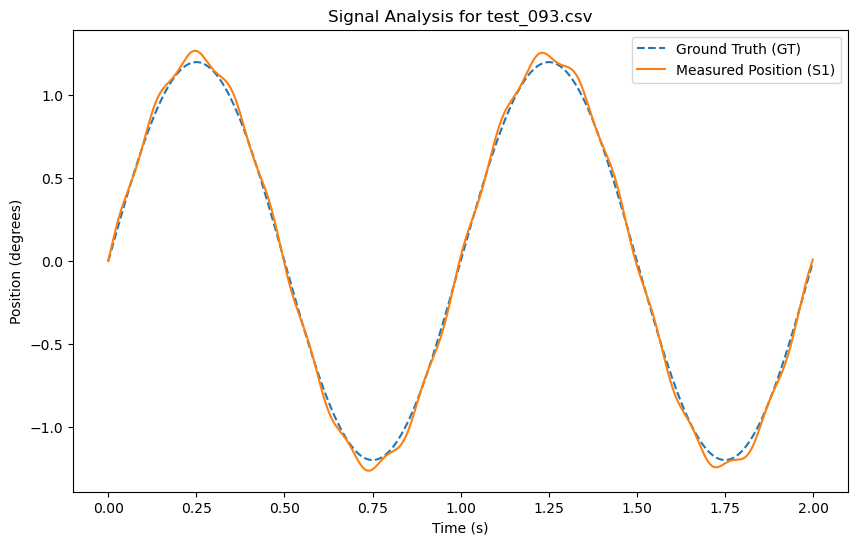

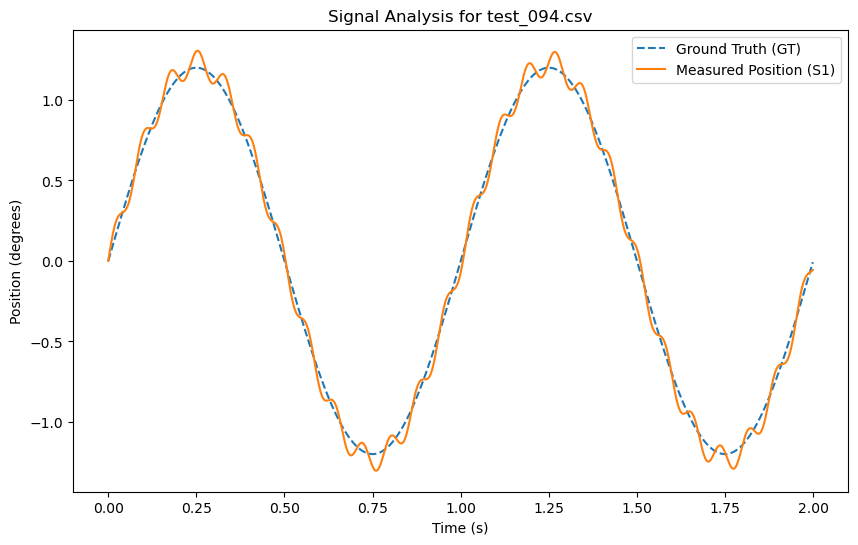

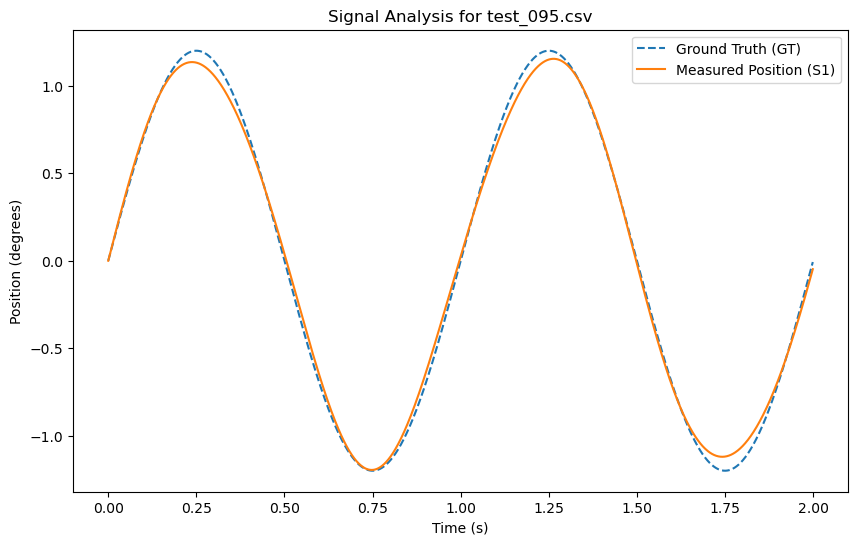

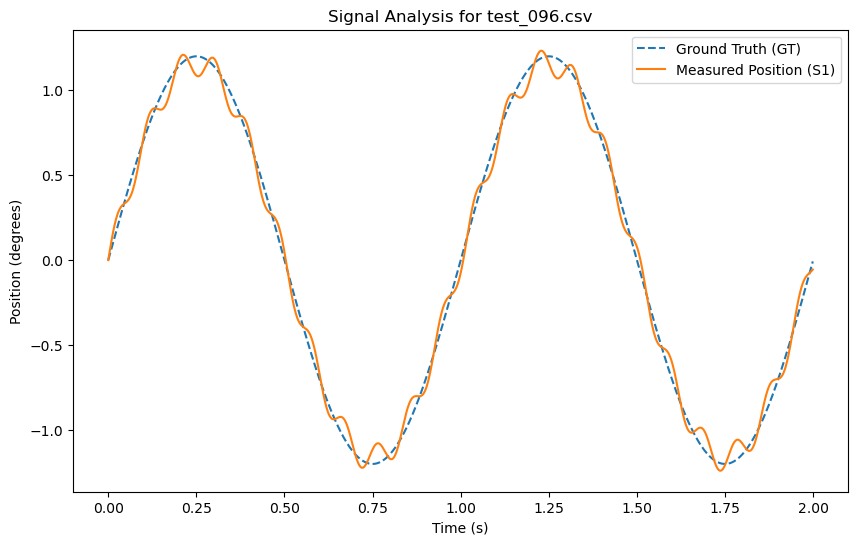

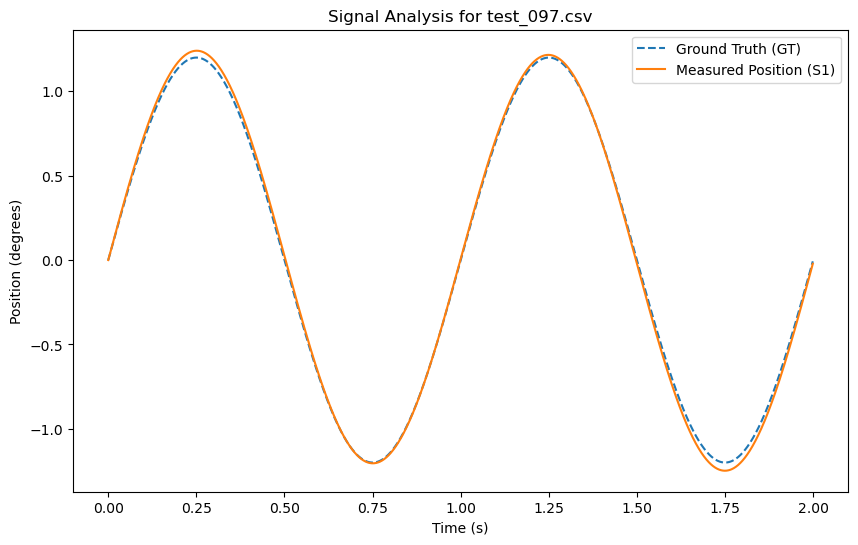

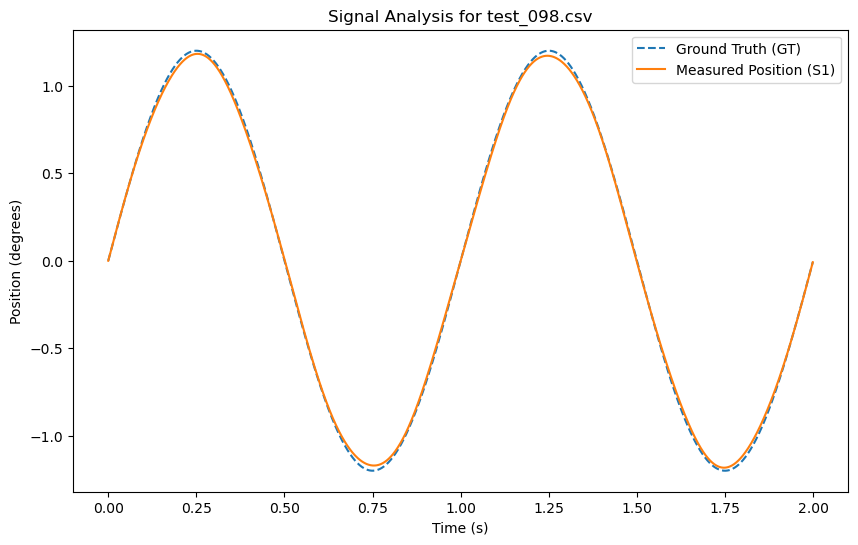

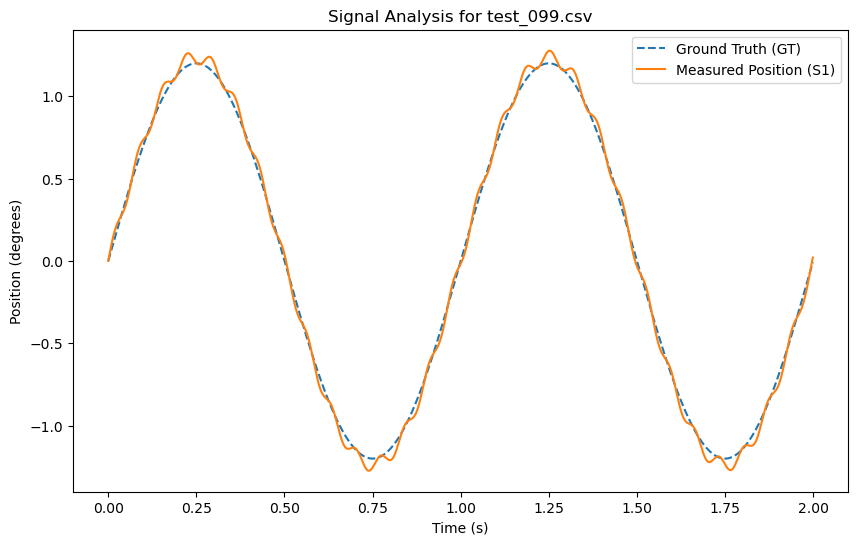

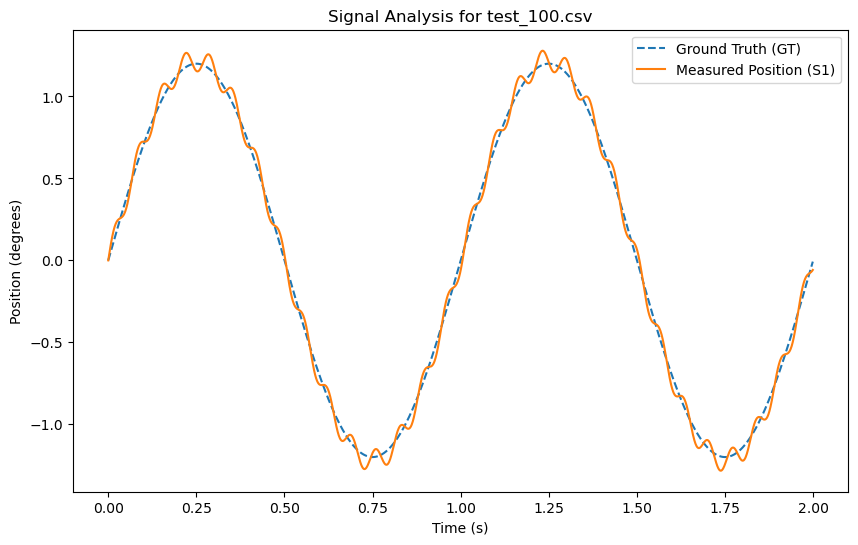

Analysis Summary:
            File  Amplitude Exceeded  Noise Amplitude  Noise Frequency  \
0   test_001.csv                True         0.111976         19.53125   
1   test_002.csv                True         0.097665         15.62500   
2   test_003.csv                True         0.121781         15.62500   
3   test_004.csv                True         0.045635         11.71875   
4   test_005.csv                True         0.113741         11.71875   
..           ...                 ...              ...              ...   
95  test_096.csv                True         0.116890         11.71875   
96  test_097.csv                True         0.048538          3.90625   
97  test_098.csv                True         0.031739          3.90625   
98  test_099.csv                True         0.076811         15.62500   
99  test_100.csv                True         0.087093         15.62500   

    Compliant  
0       False  
1       False  
2       False  
3       False  
4       False

In [38]:
# Call the processor function with the test_data folder
process_encoder_data("test_data")